<a href="https://colab.research.google.com/github/sangmu1126/NewJeanse/blob/main/Sup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/NewJeanse')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/NewJeanse


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense

# 데이터 불러오기
file1_path = 'HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv'
file2_path = 'HOME_전력거래_연료비용.csv'
file3_path = 'HOME_전력거래_전력입찰량_연료원별.csv'
file4_path = 'HOME_전력수급_최대전력수급_월별.csv'

file1 = pd.read_csv(file1_path, encoding='cp949')
file2 = pd.read_csv(file2_path, encoding='cp949')
file3 = pd.read_csv(file3_path, encoding='cp949')
file4 = pd.read_csv(file4_path, encoding='cp949')

# 데이터 전처리
# 1. 전력거래_시장참여설비용량 데이터 전처리
file1.columns = [
    '기간', '지역', '원자력', '유연탄_계', '유연탄', '무연탄', '유류', 'LNG', '양수', '신재생_계',
    '연료전지', '태양광', '풍력', '수력', '해양', '바이오', '폐기물', '신재생_총계', '기타',
    '전력시장_계', 'PPA_계', '전력시장+PPA_계'
]
columns_to_convert_file1 = ['유연탄_계', '유연탄', '무연탄', '신재생_계', '연료전지', '태양광', '풍력', '수력', '해양', '바이오', '폐기물', '신재생_총계']
for column in columns_to_convert_file1:
    file1[column] = pd.to_numeric(file1[column], errors='coerce')
file1.fillna(file1.mean(numeric_only=True), inplace=True)
file1['PPA_계'].fillna(0, inplace=True)

# 2. 전력거래_연료비용 데이터 전처리
file2.columns = [
    '기간', '연료단가_원자력', '연료단가_유연탄', '연료단가_무연탄', '연료단가_유류', '연료단가_LNG', '열량단가_원자력',
    '열량단가_유연탄', '열량단가_무연탄', '열량단가_유류', '열량단가_LNG', '연료비단가_원자력', '연료비단가_유연탄',
    '연료비단가_무연탄', '연료비단가_유류', '연료비단가_LNG'
]
columns_to_convert_file2 = [
    '연료단가_원자력', '연료단가_유연탄', '연료단가_무연탄', '연료단가_유류', '연료단가_LNG',
    '열량단가_원자력', '열량단가_유연탄', '열량단가_무연탄', '열량단가_유류', '열량단가_LNG',
    '연료비단가_원자력', '연료비단가_유연탄', '연료비단가_무연탄', '연료비단가_유류', '연료비단가_LNG'
]
for column in columns_to_convert_file2:
    file2[column] = pd.to_numeric(file2[column], errors='coerce')
file2.fillna(file2.mean(numeric_only=True), inplace=True)

# 3. 전력거래_전력입찰량 데이터 전처리
file3.columns = [
    '기간', '지역', '원자력', '유연탄', '무연탄', '유류', 'LNG', '양수', '기타', '합계'
]
columns_to_convert_file3 = ['유연탄', '무연탄', '유류', 'LNG', '양수', '기타', '합계']
for column in columns_to_convert_file3:
    file3[column] = pd.to_numeric(file3[column], errors='coerce')
file3.fillna(file3.mean(numeric_only=True), inplace=True)

# 4. 전력수급_최대전력수급 데이터 전처리
columns_to_convert_file4 = ['설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']
for column in columns_to_convert_file4:
    file4[column] = pd.to_numeric(file4[column], errors='coerce')
file4.fillna(file4.mean(numeric_only=True), inplace=True)

# 데이터 합치기
data = pd.merge(file1, file2, on='기간')
data = pd.merge(data, file3, on='기간')
data = pd.merge(data, file4, left_on='기간', right_on='일')

# 특성과 타겟 설정 (예시로 최대전력(MW)을 타겟으로 설정)
X = data.drop(['최대전력(MW)'], axis=1)
y = data['최대전력(MW)']

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import pandas as pd
import numpy as np

# Load the datasets
files = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in files.items()}

# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel'].drop(0)  # Drop the header row
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')

# Fuel Cost
fuel_cost = dataframes['fuel_cost'].drop(0)  # Drop the header row
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')

# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel'].drop(0)  # Drop the header row
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')

# Monthly Max Supply
monthly_max_supply = dataframes['monthly_max_supply']
monthly_max_supply.columns = ['년', '월', '일', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', '최대전력기준일시']
monthly_max_supply['일'] = 1  # Adding a default day to ensure proper datetime conversion
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월', '일']])
monthly_max_supply = monthly_max_supply.set_index('기간')
monthly_max_supply = monthly_max_supply[['공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]

# Merging all dataframes into one
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

data.head()


<ipython-input-13-38d58709ab69>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [ ]:
# 필요한 라이브러리 설치 (Colab에서만 필요)
!pip install tensorflow pandas scikit-learn

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load the datasets
file_paths = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in file_paths.items()}

# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel'].drop(0)  # Drop the header row
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')

# Fuel Cost
fuel_cost = dataframes['fuel_cost'].drop(0)  # Drop the header row
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')

# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel'].drop(0)  # Drop the header row
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')

# Monthly Max Supply
monthly_max_supply = dataframes['monthly_max_supply']
monthly_max_supply.columns = ['년', '월', '일', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', '최대전력기준일시']
monthly_max_supply['일'] = 1  # Adding a default day to ensure proper datetime conversion
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월', '일']])
monthly_max_supply = monthly_max_supply.set_index('기간')
monthly_max_supply = monthly_max_supply[['공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]

# Merging all dataframes into one
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data.values, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, index=data.index[-len(predictions):], columns=data.columns)
predictions_df.to_csv('/content/drive/MyDrive/predictions.csv')

# 예측 결과 확인
predictions_df.head()


<ipython-input-15-6653ee4abb5e>:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [ ]:
import pandas as pd
import numpy as np

# Load the datasets
files = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in files.items()}

# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel'].drop(0)  # Drop the header row
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')

# Fuel Cost
fuel_cost = dataframes['fuel_cost'].drop(0)  # Drop the header row
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')

# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel'].drop(0)  # Drop the header row
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')

# Monthly Max Supply
monthly_max_supply = dataframes['monthly_max_supply']
monthly_max_supply.columns = ['년', '월', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', '최대전력기준일시']
monthly_max_supply['일'] = 1  # Adding a default day to ensure proper datetime conversion
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월', '일']])
monthly_max_supply = monthly_max_supply.set_index('기간')
monthly_max_supply = monthly_max_supply[['공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]

# Merging all dataframes into one
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

data.head()


<ipython-input-20-b584b2691633>:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [day,month,year] is missing

In [ ]:
# 필요한 라이브러리 설치 (Colab에서만 필요)
!pip install tensorflow pandas scikit-learn

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# 데이터 파일 경로 설정
file_paths = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in file_paths.items()}

# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel'].drop(0)  # Drop the header row
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')

# Fuel Cost
fuel_cost = dataframes['fuel_cost'].drop(0)  # Drop the header row
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')

# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel'].drop(0)  # Drop the header row
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')

# Monthly Max Supply
monthly_max_supply = dataframes['monthly_max_supply']
monthly_max_supply.columns = ['년', '월', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)', '최대전력기준일시']
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월']].assign(day=1))
monthly_max_supply = monthly_max_supply.set_index('기간')
monthly_max_supply = monthly_max_supply[['공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]

# Merging all dataframes into one
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

data.head()


<ipython-input-21-55064cad77ed>:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


ValueError: to assemble mappings requires at least that [year, month, day] be specified: [month,year] is missing

In [12]:
import pandas as pd

# Load the datasets
files = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in files.items()}

# Display the first few rows of each dataframe to understand their structure
dataframes_previews = {name: df.head() for name, df in dataframes.items()}
dataframes_previews


{'market_capacity_by_fuel':         기간   지역      원자력                 석탄 Unnamed: 4         Unnamed: 5  \
 0      NaN  NaN      NaN                유연탄        무연탄                  계   
 1  2024/06   합계  26050.0  41339.78200000001        400  41739.78200000001   
 2  2024/05   합계  26050.0  40289.78200000001        400  40689.78200000001   
 3  2024/04   합계  26050.0  40289.78200000001        400  40689.78200000001   
 4  2024/03   합계  26050.0  40289.78200000001        400  40689.78200000001   
 
       유류      LNG      양수                 신재생  ...         Unnamed: 12  \
 0    NaN      NaN     NaN                연료전지  ...                  풍력   
 1  531.0  47573.4  4700.0  1047.5079999999994  ...  2230.9429999999998   
 2  531.0  46848.2  4700.0  1027.7079999999994  ...            2226.743   
 3  574.5  45242.0  4700.0  1027.5879999999995  ...            2226.743   
 4  614.5  45242.0  4700.0  1027.5879999999995  ...            2192.343   
 
           Unnamed: 13 Unnamed: 14         Unnamed:

In [13]:
# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel']
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')
market_capacity.head()


전력시장+PPA계
기간                    
2024-06-01  142694.315
2024-05-01  140475.350
2024-04-01  138813.551
2024-03-01  138731.239
2024-02-01  154696.083

In [14]:
# Fuel Cost
fuel_cost = dataframes['fuel_cost']
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')
fuel_cost.head()


<ipython-input-14-7233bc3ab60b>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
<ipython-input-14-7233bc3ab60b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


연료비단가_유연탄 연료비단가_유류 연료비단가_LNG
기간                                     
NaT              유연탄       유류       LNG
NaT            원/kWh    원/kWh     원/kWh
2024-07-01    78.269  360.015   133.075
2024-06-01    78.273  358.215   130.587
2024-05-01    78.491  345.997  133.1954

In [15]:
# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel']
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')
bid_volume.head()


합계
기간                     
2024-06-01  59407.68946
2024-05-01  57661.82104
2024-04-01  57862.56452
2024-03-01  62622.31631
2024-02-01  66081.99001

In [16]:
import pandas as pd

# Load the dataset
file_path = "HOME_전력수급_최대전력수급_월별.csv"

# Read the CSV file with encoding to handle potential issues
monthly_max_supply = pd.read_csv(file_path, encoding='cp949')

# Convert '년' and '월' to a datetime period without specifying '일'
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월']].astype(str).agg('-'.join, axis=1))

# Setting the period as index
monthly_max_supply = monthly_max_supply.set_index('기간')

# Selecting the necessary columns
monthly_max_supply = monthly_max_supply[['설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]

# Display the processed dataframe
monthly_max_supply.head()


설비용량(MW)  공급능력(MW)  최대전력(MW)  공급예비력(MW)  공급예비율(%)
기간                                                           
2024-07-01    148917     98615     84567      14048      16.6
2024-06-01    148089     89170     80077       9093      11.4
2024-05-01    147999     82585     69899      12686      18.1
2024-04-01    145191     83155     71199      11956      16.8
2024-03-01    145013     95500     81691      13809      16.9

In [17]:
import pandas as pd

# Load the datasets
files = {
    "market_capacity_by_fuel": "HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv",
    "fuel_cost": "HOME_전력거래_연료비용.csv",
    "bid_volume_by_fuel": "HOME_전력거래_전력입찰량_연료원별.csv",
    "monthly_max_supply": "HOME_전력수급_최대전력수급_월별.csv"
}

# Reading the CSV files with encoding to handle potential issues
dataframes = {name: pd.read_csv(path, encoding='cp949') for name, path in files.items()}

# Display the first few rows of each dataframe to understand their structure
dataframes_previews = {name: df.head() for name, df in dataframes.items()}
dataframes_previews


{'market_capacity_by_fuel':         기간   지역      원자력                 석탄 Unnamed: 4         Unnamed: 5  \
 0      NaN  NaN      NaN                유연탄        무연탄                  계   
 1  2024/06   합계  26050.0  41339.78200000001        400  41739.78200000001   
 2  2024/05   합계  26050.0  40289.78200000001        400  40689.78200000001   
 3  2024/04   합계  26050.0  40289.78200000001        400  40689.78200000001   
 4  2024/03   합계  26050.0  40289.78200000001        400  40689.78200000001   
 
       유류      LNG      양수                 신재생  ...         Unnamed: 12  \
 0    NaN      NaN     NaN                연료전지  ...                  풍력   
 1  531.0  47573.4  4700.0  1047.5079999999994  ...  2230.9429999999998   
 2  531.0  46848.2  4700.0  1027.7079999999994  ...            2226.743   
 3  574.5  45242.0  4700.0  1027.5879999999995  ...            2226.743   
 4  614.5  45242.0  4700.0  1027.5879999999995  ...            2192.343   
 
           Unnamed: 13 Unnamed: 14         Unnamed:

In [18]:
# Market Capacity by Fuel
market_capacity = dataframes['market_capacity_by_fuel']
market_capacity.columns = [
    "기간", "지역", "원자력", "유연탄", "무연탄", "석탄계", "유류", "LNG", "양수", "연료전지", "신재생계",
    "태양광", "풍력", "수력", "해양", "바이오", "폐기물", "신재생기타", "기타", "전력시장계", "PPA계", "전력시장+PPA계"
]
market_capacity = market_capacity[["기간", "지역", "전력시장+PPA계"]]
market_capacity = market_capacity[market_capacity['지역'] == '합계']
market_capacity['기간'] = pd.to_datetime(market_capacity['기간'], format='%Y/%m')
market_capacity = market_capacity.set_index('기간')
market_capacity = market_capacity.drop(columns='지역')
market_capacity.head()


전력시장+PPA계
기간                    
2024-06-01  142694.315
2024-05-01  140475.350
2024-04-01  138813.551
2024-03-01  138731.239
2024-02-01  154696.083

In [19]:
# Fuel Cost
fuel_cost = dataframes['fuel_cost']
fuel_cost.columns = [
    "기간", "연료단가_원자력", "연료단가_유연탄", "연료단가_무연탄", "연료단가_유류", "연료단가_LNG", "열량단가_원자력",
    "열량단가_유연탄", "열량단가_무연탄", "열량단가_유류", "열량단가_LNG", "연료비단가_원자력", "연료비단가_유연탄",
    "연료비단가_무연탄", "연료비단가_유류", "연료비단가_LNG"
]
fuel_cost = fuel_cost[["기간", "연료비단가_유연탄", "연료비단가_유류", "연료비단가_LNG"]]
fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
fuel_cost = fuel_cost.set_index('기간')
fuel_cost.head()


<ipython-input-19-7233bc3ab60b>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])
<ipython-input-19-7233bc3ab60b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fuel_cost['기간'] = pd.to_datetime(fuel_cost['기간'])


연료비단가_유연탄 연료비단가_유류 연료비단가_LNG
기간                                     
NaT              유연탄       유류       LNG
NaT            원/kWh    원/kWh     원/kWh
2024-07-01    78.269  360.015   133.075
2024-06-01    78.273  358.215   130.587
2024-05-01    78.491  345.997  133.1954

In [20]:
# Bid Volume by Fuel
bid_volume = dataframes['bid_volume_by_fuel']
bid_volume.columns = ["기간", "지역", "원자력", "유연탄", "무연탄", "유류", "LNG", "양수", "기타", "합계"]
bid_volume = bid_volume[["기간", "지역", "합계"]]
bid_volume = bid_volume[bid_volume['지역'] == '합계']
bid_volume['기간'] = pd.to_datetime(bid_volume['기간'], format='%b-%y')
bid_volume = bid_volume.set_index('기간')
bid_volume = bid_volume.drop(columns='지역')
bid_volume.head()


합계
기간                     
2024-06-01  59407.68946
2024-05-01  57661.82104
2024-04-01  57862.56452
2024-03-01  62622.31631
2024-02-01  66081.99001

In [21]:
# Monthly Max Supply
monthly_max_supply = dataframes['monthly_max_supply']
monthly_max_supply.columns = ['년', '월', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']
monthly_max_supply['기간'] = pd.to_datetime(monthly_max_supply[['년', '월']].astype(str).agg('-'.join, axis=1))
monthly_max_supply = monthly_max_supply.set_index('기간')
monthly_max_supply = monthly_max_supply[['설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)', '공급예비율(%)']]
monthly_max_supply.head()


설비용량(MW)  공급능력(MW)  최대전력(MW)  공급예비력(MW)  공급예비율(%)
기간                                                           
2024-07-01    148917     98615     84567      14048      16.6
2024-06-01    148089     89170     80077       9093      11.4
2024-05-01    147999     82585     69899      12686      18.1
2024-04-01    145191     83155     71199      11956      16.8
2024-03-01    145013     95500     81691      13809      16.9

In [23]:
# Merging all dataframes into one
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

data.head()


전력시장+PPA계         연료비단가_유연탄          연료비단가_유류         연료비단가_LNG  \
기간                                                                            
2015-01-01  94284.941  39.6406834823358  204.215638712073  146.243898125579   
2015-02-01  95586.882              39.6            200.51             130.4   
2015-03-01  95640.938  38.9442731634237  174.032817095516  121.829884860736   
2015-04-01  95926.764  37.1656207845752  161.361008482994  107.833490463371   
2015-05-01  96129.023  37.1775611036321  159.507092760489  101.242734843183   

                     합계  설비용량(MW)  공급능력(MW)  최대전력(MW)  공급예비력(MW)  공급예비율(%)  
기간                                                                          
2015-01-01  57921.05382     92825     90501     77796      12705      16.3  
2015-02-01  50891.77234     94102     87926     78790       9136      11.6  
2015-03-01  54289.29060     94102     84910     75375       9535      12.7  
2015-04-01  49836.82940     95365     79635     66582      13053      19.6  
2015-05-01  48383.19678     95681     76874     67107       9767      14.6

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

# Function to create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data.values, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Save predictions to CSV
predictions_df = pd.DataFrame(predictions, index=data.index[-len(predictions):], columns=data.columns)
predictions_df.to_csv('predictions.csv')

# 예측 결과 확인
predictions_df.head()


NameError: name 'data' is not defined

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


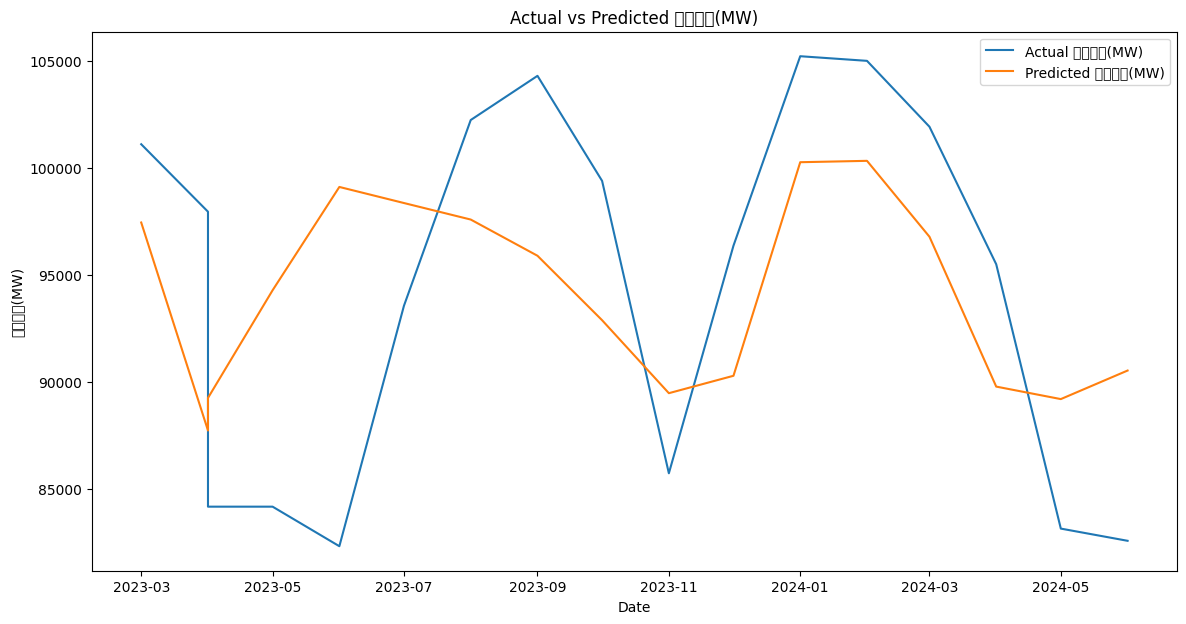

In [ ]:
import matplotlib.pyplot as plt

# Create a DataFrame to compare predictions and actual values
comparison_df = pd.DataFrame({
    'Date': data.index[-len(predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'Predicted 공급능력(MW)': predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# Plot the comparison
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Predicted 공급능력(MW)'], label='Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW)')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


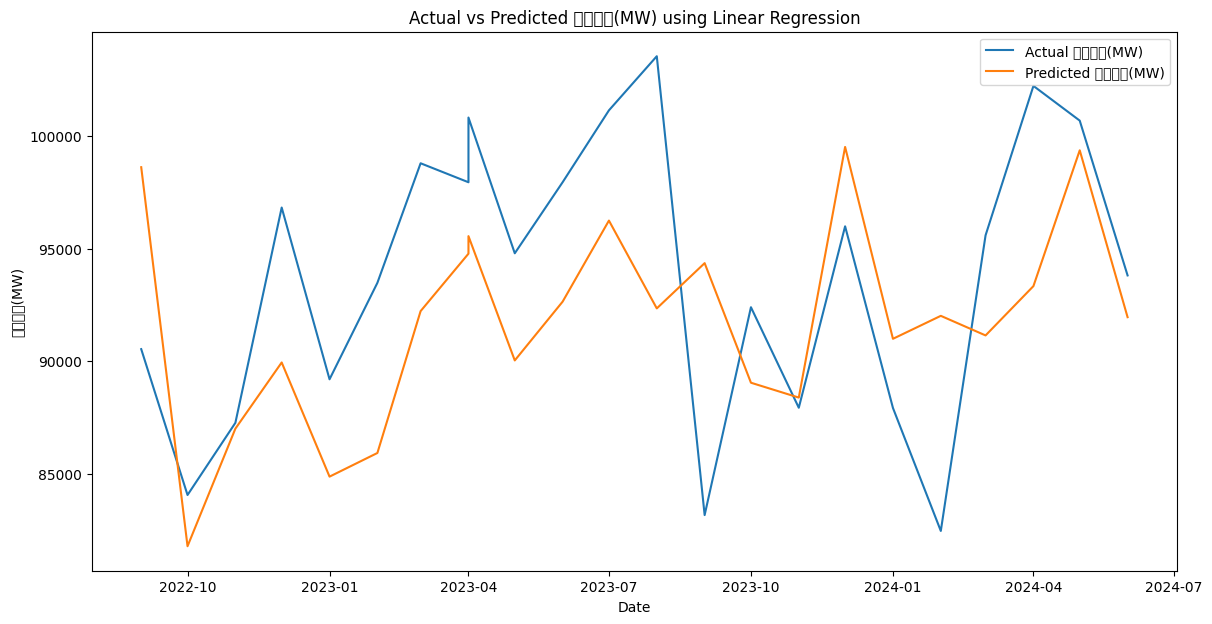

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 1  # 선형 회귀의 경우 시퀀스 길이가 1인 데이터를 사용
X, y = create_dataset(scaled_data, time_step)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 및 학습
model = LinearRegression()
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 예측 수행
predictions = model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값과 실제값을 역변환
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'Predicted 공급능력(MW)': predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Predicted 공급능력(MW)'], label='Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Linear Regression')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


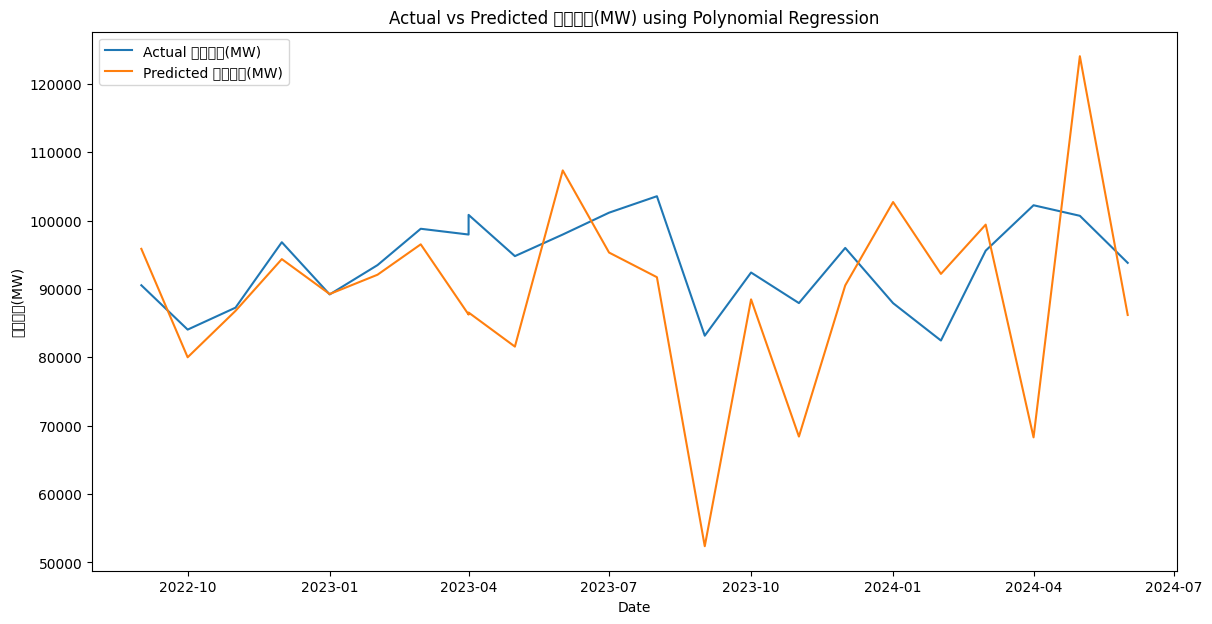

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 피처 엔지니어링 - 시간 관련 피처 추가
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 1  # 선형 회귀의 경우 시퀀스 길이가 1인 데이터를 사용
X, y = create_dataset(scaled_data, time_step)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 다항 회귀 사용
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_poly = poly.transform(X_test.reshape(X_test.shape[0], -1))

# 모델 정의 및 학습
model = LinearRegression()
model.fit(X_train_poly, y_train)

# 예측 수행
predictions = model.predict(X_test_poly)

# 예측값과 실제값을 역변환
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'Predicted 공급능력(MW)': predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Predicted 공급능력(MW)'], label='Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Polynomial Regression')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


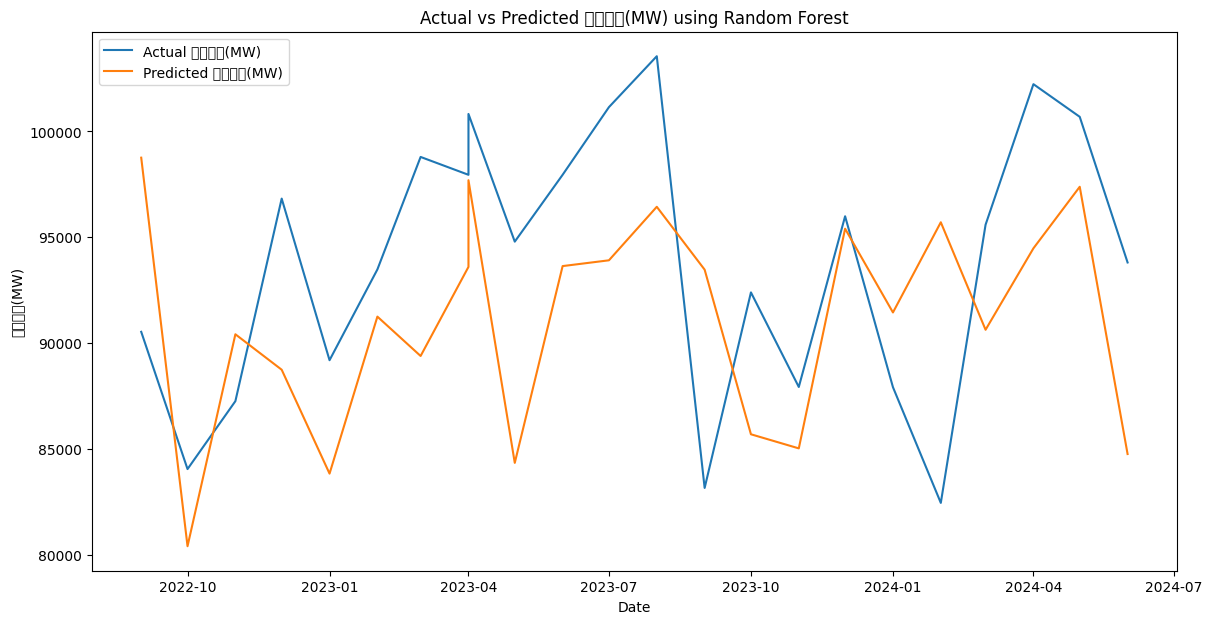

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 피처 엔지니어링 - 시간 관련 피처 추가
data['Year'] = data.index.year
data['Month'] = data.index.month
data['Quarter'] = data.index.quarter

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 1  # 랜덤 포레스트의 경우 시퀀스 길이가 1인 데이터를 사용
X, y = create_dataset(scaled_data, time_step)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 정의 및 학습
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# 예측 수행
predictions = model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값과 실제값을 역변환
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'Predicted 공급능력(MW)': predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Predicted 공급능력(MW)'], label='Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Random Forest')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 30  # LSTM의 경우 시퀀스 길이를 30으로 사용
X, y = create_dataset(scaled_data, time_step)

# train-test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(128, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)


Epoch 1/50
3/3 [==============================] - 4s 372ms/step - loss: 0.2336 - val_loss: 0.2116
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 0.1170 - val_loss: 0.0688
Epoch 3/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0638 - val_loss: 0.0804
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0587 - val_loss: 0.0875
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0566 - val_loss: 0.0779
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0521 - val_loss: 0.0600
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0519 - val_loss: 0.0465
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0458 - val_loss: 0.0427
Epoch 9/50
3/3 [==============================] - 0s 19ms/step - loss: 0.0469 - val_loss: 0.0429
Epoch 10/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0413 - val_loss: 0.0497
Epoch 11/50
3/3 [===========

1/1 [==============================] - 1s 636ms/step


In [ ]:
# 랜덤 포레스트 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
X_train_rf = X_train.reshape(X_train.shape[0], -1)
X_test_rf = X_test.reshape(X_test.shape[0], -1)
rf_model.fit(X_train_rf, y_train)

# 예측 수행
rf_predictions = rf_model.predict(X_test_rf)

# 예측값과 실제값을 역변환
rf_predictions = scaler.inverse_transform(rf_predictions)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


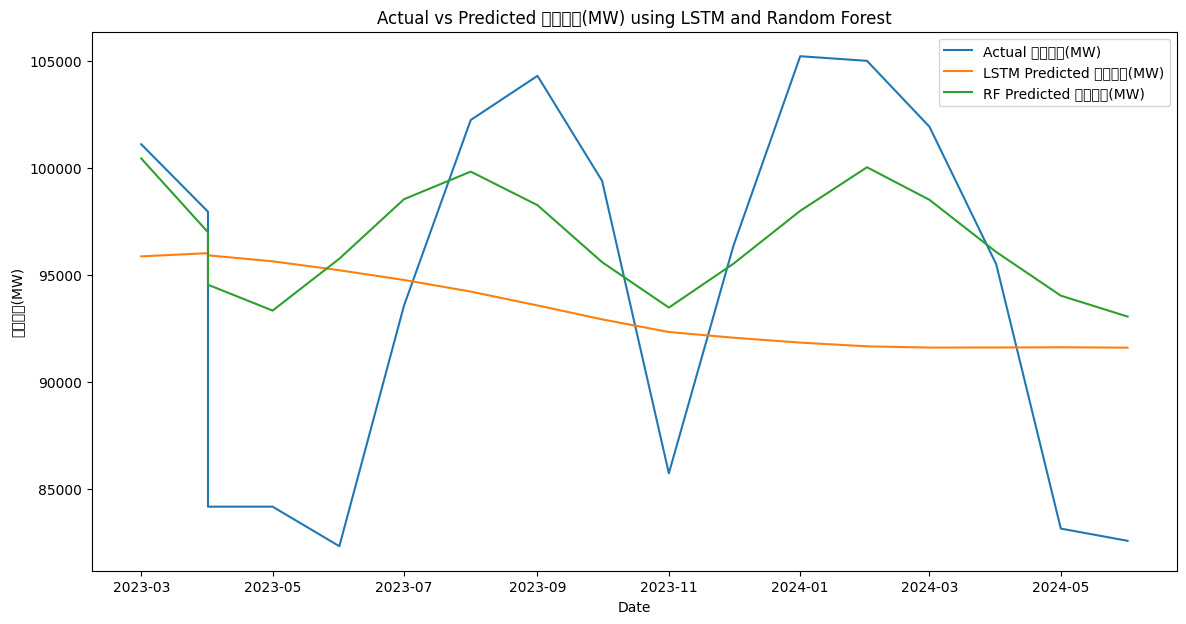

In [ ]:
# Create a DataFrame to compare predictions and actual values
comparison_df = pd.DataFrame({
    'Date': data.index[-len(lstm_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'RF Predicted 공급능력(MW)': rf_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['RF Predicted 공급능력(MW)'], label='RF Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM and Random Forest')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 30  # LSTM의 경우 시퀀스 길이를 30으로 사용
X, y = create_dataset(scaled_data, time_step)

# train-test split
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)


Epoch 1/50
3/3 [==============================] - 5s 602ms/step - loss: 0.0334 - val_loss: 0.0638
Epoch 2/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0291 - val_loss: 0.0612
Epoch 3/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0273 - val_loss: 0.1031
Epoch 4/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0281 - val_loss: 0.0783
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0256 - val_loss: 0.0618
Epoch 6/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0266 - val_loss: 0.0700
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0259 - val_loss: 0.0899
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 0.0267 - val_loss: 0.0922
Epoch 9/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0250 - val_loss: 0.0667
Epoch 10/50
3/3 [==============================] - 0s 21ms/step - loss: 0.0268 - val_loss: 0.0529
Epoch 11/50
3/3 [===========

In [ ]:
# 선형 회귀 모델 정의 및 학습
linear_model = LinearRegression()
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)
linear_model.fit(X_train_lr, y_train)

# 예측 수행
linear_predictions = linear_model.predict(X_test_lr)

# 예측값과 실제값을 역변환
linear_predictions = scaler.inverse_transform(linear_predictions)


In [ ]:
# 앙상블 예측 - 단순 평균
ensemble_predictions = (lstm_predictions + linear_predictions) / 2


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


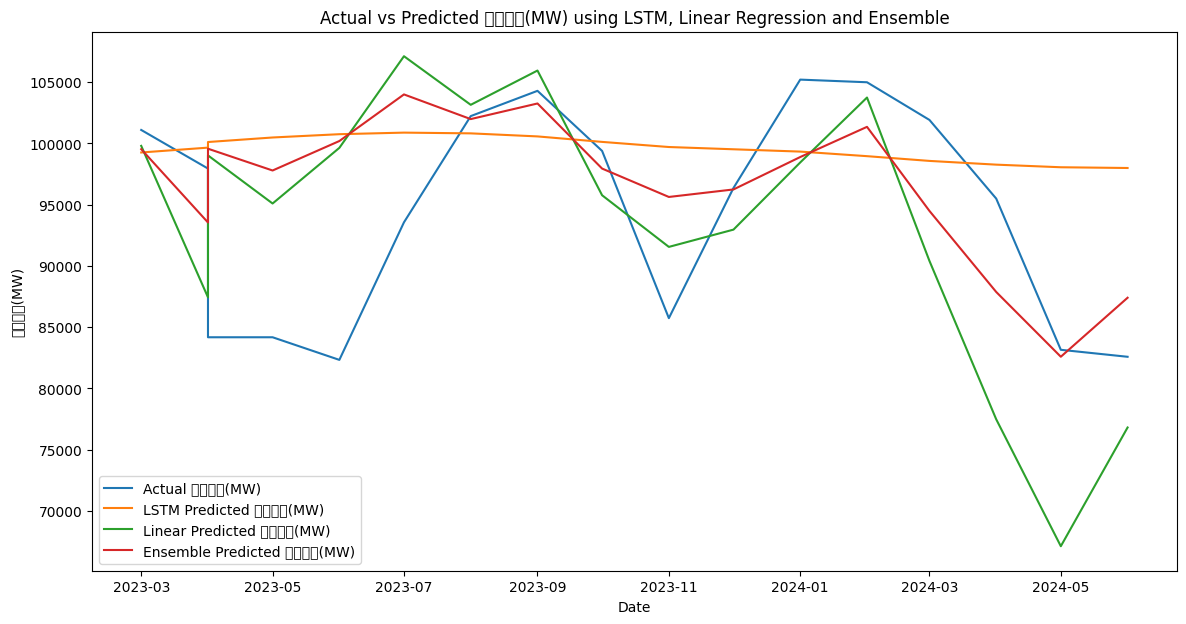

In [ ]:
# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Linear Predicted 공급능력(MW)': linear_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Linear Predicted 공급능력(MW)'], label='Linear Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Linear Regression and Ensemble')
plt.legend()
plt.show()


Epoch 1/50
68/68 [==============================] - 3s 5ms/step - loss: 0.0567
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0260
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 10/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 11/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 12/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 13/50
68/68 [==============================

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


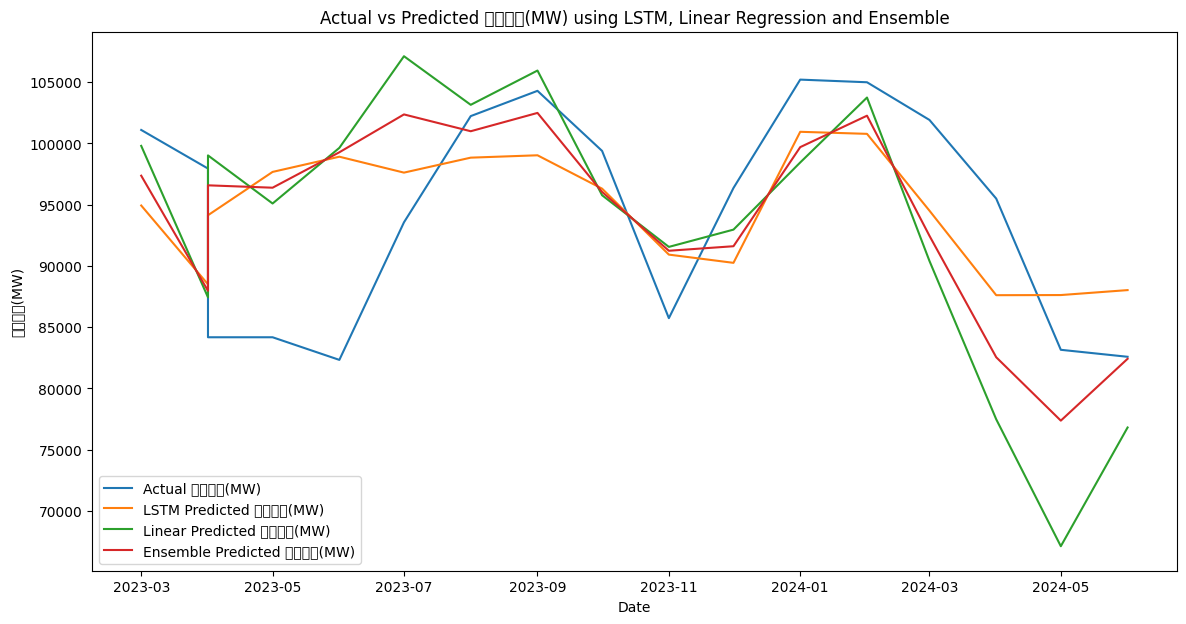

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 선형 회귀 모델 정의 및 학습
linear_model = LinearRegression()
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)
linear_model.fit(X_train_lr, y_train)

# 예측 수행
linear_predictions = linear_model.predict(X_test_lr)

# 예측값과 실제값을 역변환
linear_predictions = scaler.inverse_transform(linear_predictions)

# 앙상블 예측 - 단순 평균
ensemble_predictions = (lstm_predictions + linear_predictions) / 2

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Linear Predicted 공급능력(MW)': linear_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Linear Predicted 공급능력(MW)'], label='Linear Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Linear Regression and Ensemble')
plt.legend()
plt.show()


Epoch 1/50
68/68 [==============================] - 3s 6ms/step - loss: 0.0544
Epoch 2/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0316
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0303
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 10/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 11/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 12/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0273
Epoch 13/50
68/68 [==============================

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


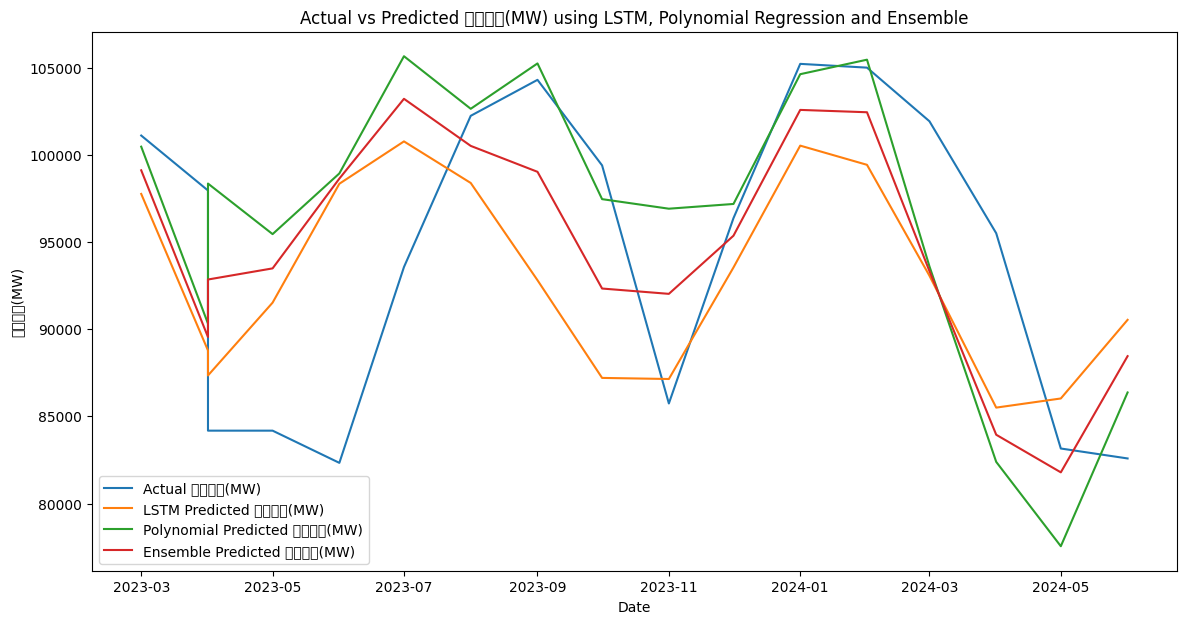

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 다항 회귀 모델 정의 및 학습
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_poly = poly.transform(X_test.reshape(X_test.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# 예측 수행
poly_predictions = linear_model.predict(X_test_poly)

# 예측값과 실제값을 역변환
poly_predictions = scaler.inverse_transform(poly_predictions)

# 앙상블 예측 - 단순 평균
ensemble_predictions = (lstm_predictions + poly_predictions) / 2

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Polynomial Predicted 공급능력(MW)': poly_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Polynomial Predicted 공급능력(MW)'], label='Polynomial Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Polynomial Regression and Ensemble')
plt.legend()
plt.show()


Epoch 1/50
68/68 [==============================] - 3s 6ms/step - loss: 0.0757
Epoch 2/50
68/68 [==============================] - 0s 7ms/step - loss: 0.0370
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0311
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0293
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 8/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 10/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 11/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0261
Epoch 12/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 13/50
68/68 [==============================

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


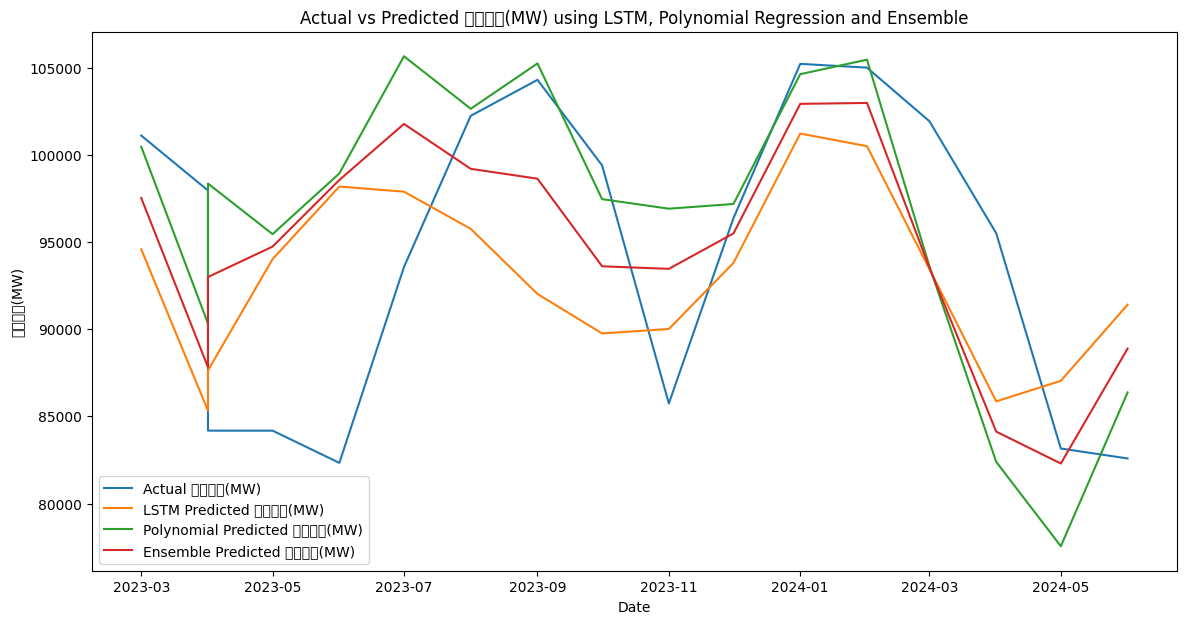

LSTM Mean Squared Error: 69696896.59966682
LSTM Mean Absolute Error: 7480.00643382353
LSTM R2 Score: 0.03591606001497827
Polynomial Regression Mean Squared Error: 72106292.88584472
Polynomial Regression Mean Absolute Error: 6442.96528289641
Polynomial Regression R2 Score: 0.0025880299606992896
Ensemble Mean Squared Error: 59998045.09618221
Ensemble Mean Absolute Error: 6579.481574833413
Ensemble R2 Score: 0.17007564856190638


In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 다항 회귀 모델 정의 및 학습
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_poly = poly.transform(X_test.reshape(X_test.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# 예측 수행
poly_predictions = linear_model.predict(X_test_poly)

# 예측값과 실제값을 역변환
poly_predictions = scaler.inverse_transform(poly_predictions)

# 앙상블 예측 - 단순 평균
ensemble_predictions = (lstm_predictions + poly_predictions) / 2

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Polynomial Predicted 공급능력(MW)': poly_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Polynomial Predicted 공급능력(MW)'], label='Polynomial Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Polynomial Regression and Ensemble')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_lstm = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['LSTM Predicted 공급능력(MW)'])
mae_lstm = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['LSTM Predicted 공급능력(MW)'])
r2_lstm = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['LSTM Predicted 공급능력(MW)'])

mse_poly = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Polynomial Predicted 공급능력(MW)'])
mae_poly = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Polynomial Predicted 공급능력(MW)'])
r2_poly = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Polynomial Predicted 공급능력(MW)'])

mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])

print("LSTM Mean Squared Error:", mse_lstm)
print("LSTM Mean Absolute Error:", mae_lstm)
print("LSTM R2 Score:", r2_lstm)

print("Polynomial Regression Mean Squared Error:", mse_poly)
print("Polynomial Regression Mean Absolute Error:", mae_poly)
print("Polynomial Regression R2 Score:", r2_poly)

print("Ensemble Mean Squared Error:", mse_ensemble)
print("Ensemble Mean Absolute Error:", mae_ensemble)
print("Ensemble R2 Score:", r2_ensemble)


Epoch 1/50
68/68 [==============================] - 3s 6ms/step - loss: 0.0548
Epoch 2/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0365
Epoch 3/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 4/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 5/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 6/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 7/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 8/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0270
Epoch 9/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0257
Epoch 10/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0262
Epoch 11/50
68/68 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 12/50
68/68 [==============================] - 0s 6ms/step - loss: 0.0261
Epoch 13/50
68/68 [==============================

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


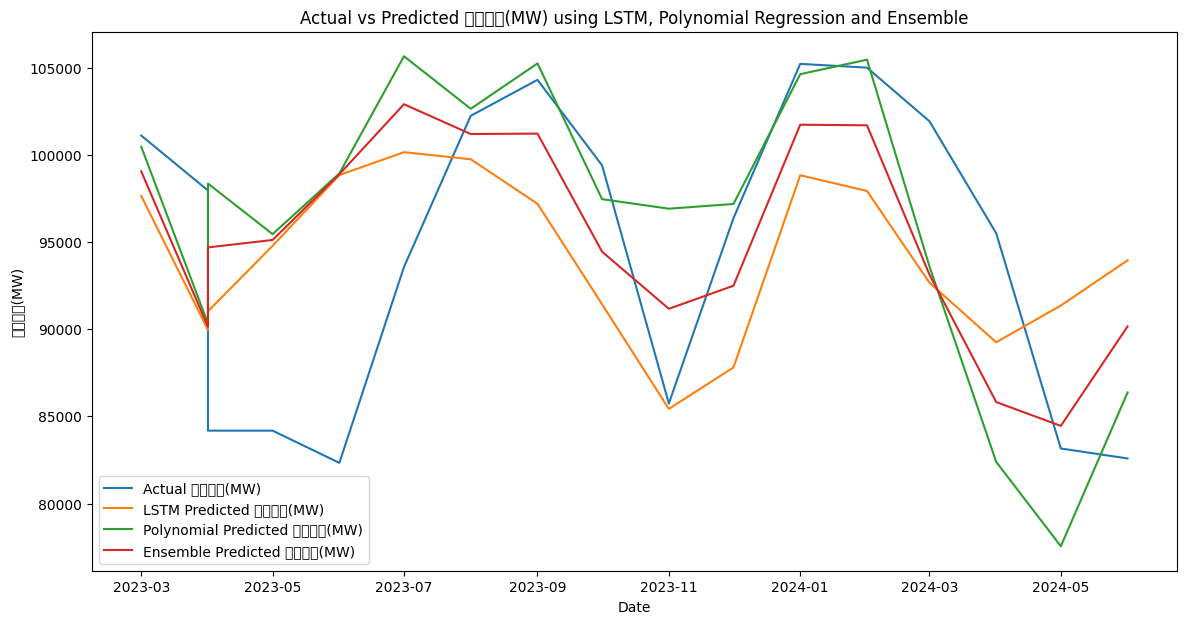

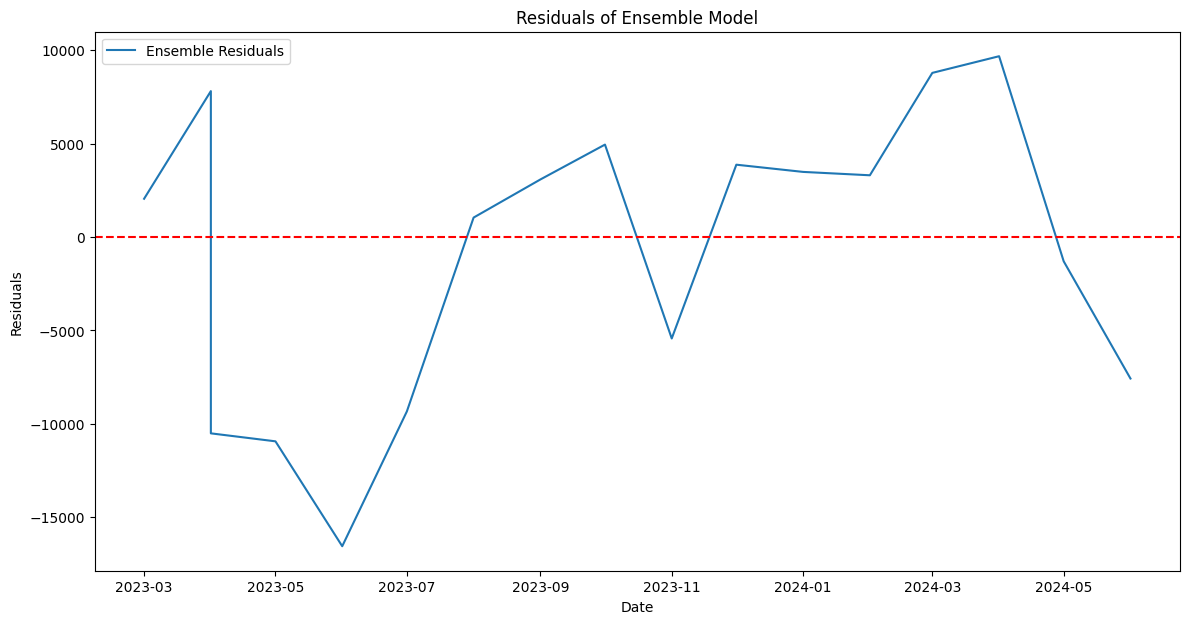

Ensemble Mean Squared Error: 58186486.319601394
Ensemble Mean Absolute Error: 6454.0811136158345
Ensemble R2 Score: 0.19513407738797306


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 다항 회귀 모델 정의 및 학습
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_poly = poly.transform(X_test.reshape(X_test.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# 예측 수행
poly_predictions = linear_model.predict(X_test_poly)

# 예측값과 실제값을 역변환
poly_predictions = scaler.inverse_transform(poly_predictions)

# 앙상블 예측 - 단순 평균
ensemble_predictions = (lstm_predictions + poly_predictions) / 2

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Polynomial Predicted 공급능력(MW)': poly_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 잔차 계산
comparison_df['Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Polynomial Predicted 공급능력(MW)'], label='Polynomial Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Polynomial Regression and Ensemble')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Ensemble Residuals'], label='Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Ensemble Model')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])

print("Ensemble Mean Squared Error:", mse_ensemble)
print("Ensemble Mean Absolute Error:", mae_ensemble)
print("Ensemble R2 Score:", r2_ensemble)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=50)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions and actual values
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# 다항 회귀 모델 정의 및 학습
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_poly = poly.transform(X_test.reshape(X_test.shape[0], -1))

linear_model = LinearRegression()
linear_model.fit(X_train_poly, y_train)

# 예측 수행
poly_predictions = linear_model.predict(X_test_poly)

# 예측값과 실제값을 역변환
poly_predictions = scaler.inverse_transform(poly_predictions)

# 앙상블 예측 - 가중치 평균 (가중치 예: LSTM 0.6, Polynomial 0.4)
ensemble_predictions = (0.6 * lstm_predictions + 0.4 * poly_predictions)

# 예측값과 실제값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': data.index[-len(ensemble_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, data.columns.get_loc('공급능력(MW)')],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Polynomial Predicted 공급능력(MW)': poly_predictions[:, data.columns.get_loc('공급능력(MW)')],
    'Ensemble Predicted 공급능력(MW)': ensemble_predictions[:, data.columns.get_loc('공급능력(MW)')]
})

# 잔차 계산
comparison_df['Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Polynomial Predicted 공급능력(MW)'], label='Polynomial Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Ensemble Predicted 공급능력(MW)'], label='Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using LSTM, Polynomial Regression and Ensemble')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Ensemble Residuals'], label='Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Ensemble Model')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Ensemble Predicted 공급능력(MW)'])

print("Ensemble Mean Squared Error:", mse_ensemble)
print("Ensemble Mean Absolute Error:", mae_ensemble)
print("Ensemble R2 Score:", r2_ensemble)


NameError: name 'market_capacity' is not defined

Epoch 1/100
68/68 [==============================] - 4s 6ms/step - loss: 0.0739
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0389
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0302
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0263
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0256
Epoch 11/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 12/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0248
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


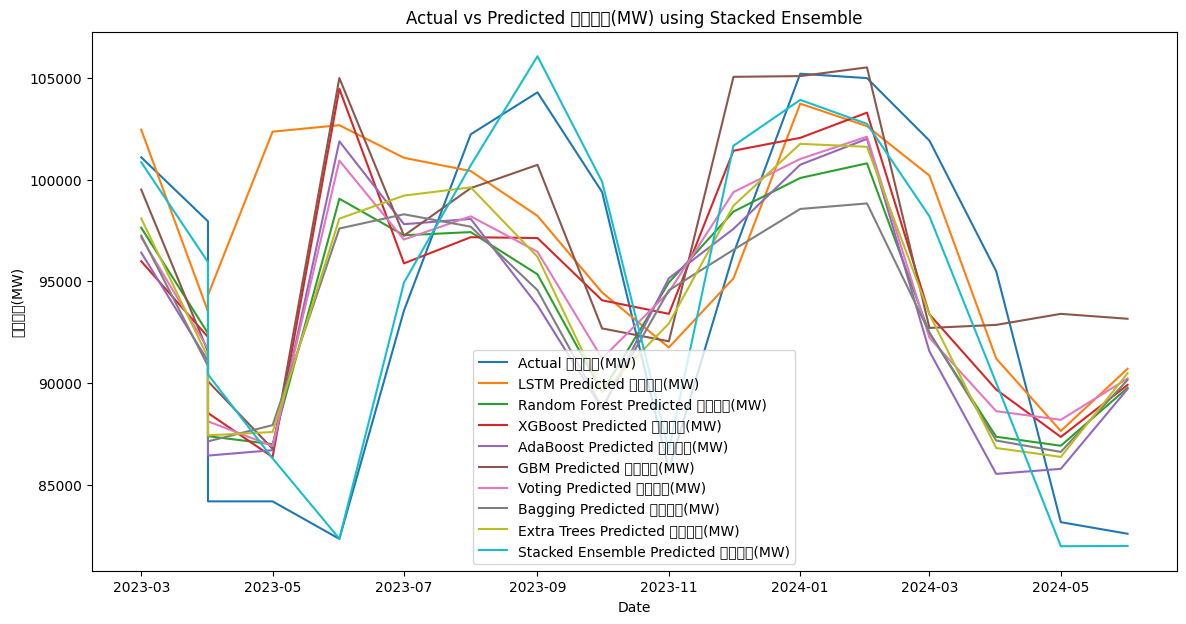

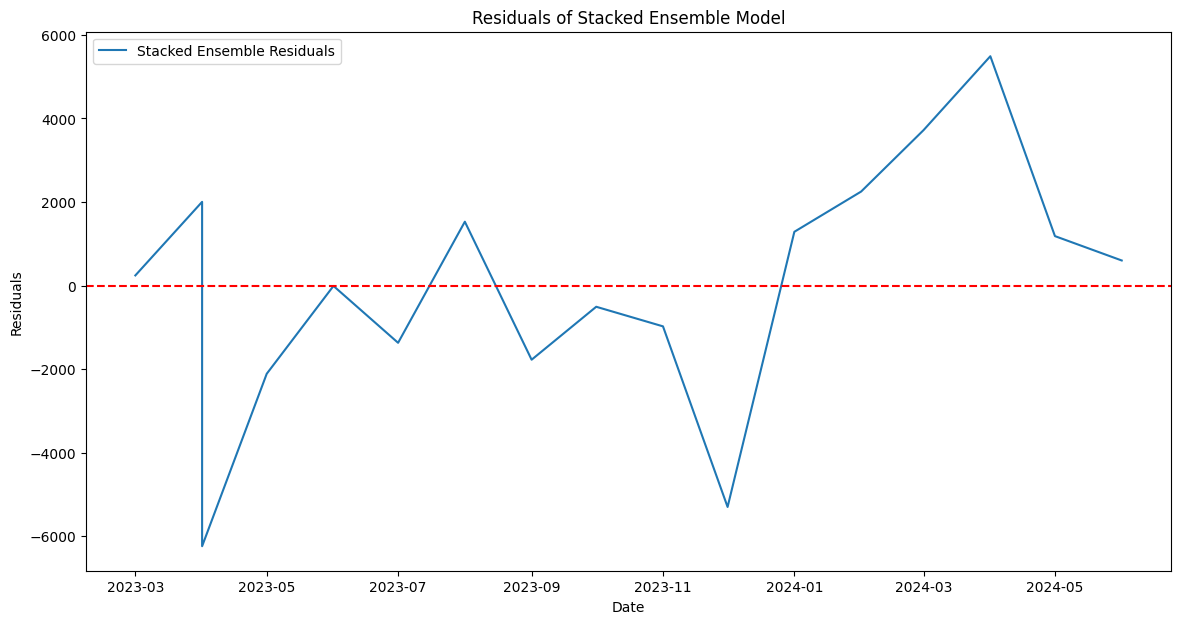

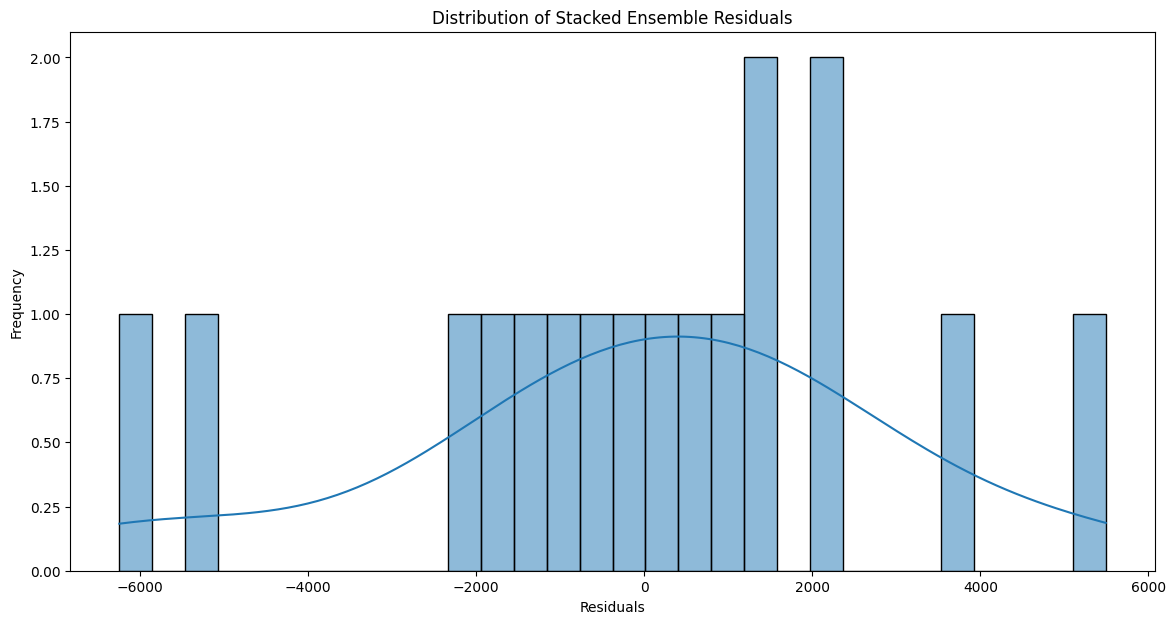

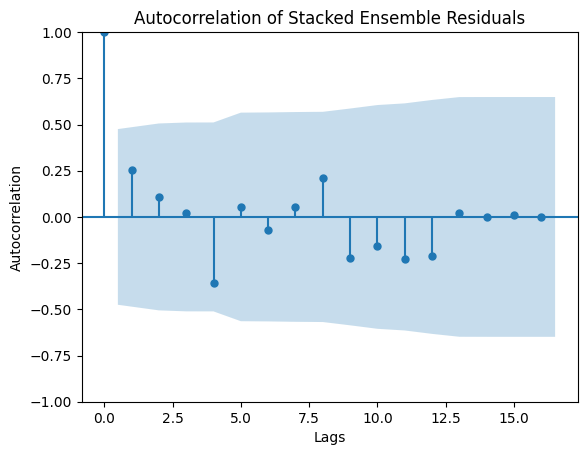

Stacked Ensemble Mean Squared Error: 8042818.9829194145
Stacked Ensemble Mean Absolute Error: 2153.7650750016346
Stacked Ensemble R2 Score: 0.8887475197328034
LSTM Performance:
Mean Squared Error: 67229242.7756635
Mean Absolute Error: 6146.21875
R2 Score: 0.07004993881347288

Random Forest Performance:
Mean Squared Error: 53454113.497629374
Mean Absolute Error: 6362.446470588231
R2 Score: 0.2605947342934145

XGBoost Performance:
Mean Squared Error: 56373477.79350984
Mean Absolute Error: 6047.061956524849
R2 Score: 0.22021255990779787

AdaBoost Performance:
Mean Squared Error: 65023988.19615154
Mean Absolute Error: 6682.912408018128
R2 Score: 0.10055417397185806

GBM Performance:
Mean Squared Error: 64811587.84844251
Mean Absolute Error: 6123.123297681282
R2 Score: 0.1034922067116757

Voting Performance:
Mean Squared Error: 53966198.79122057
Mean Absolute Error: 6301.016540790798
R2 Score: 0.25351130258354204

Bagging Performance:
Mean Squared Error: 56417870.038811326
Mean Absolute Err

<Figure size 1400x700 with 0 Axes>

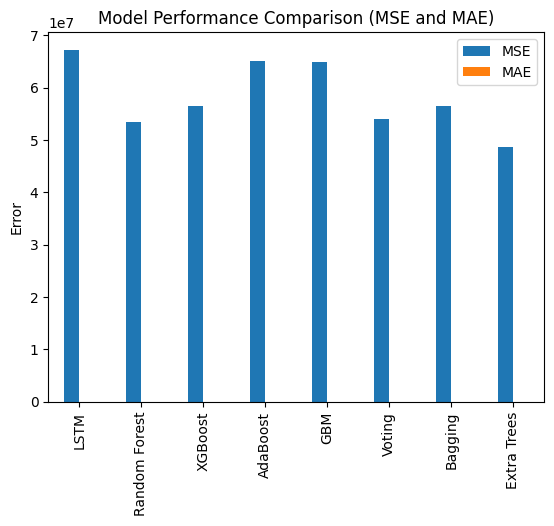

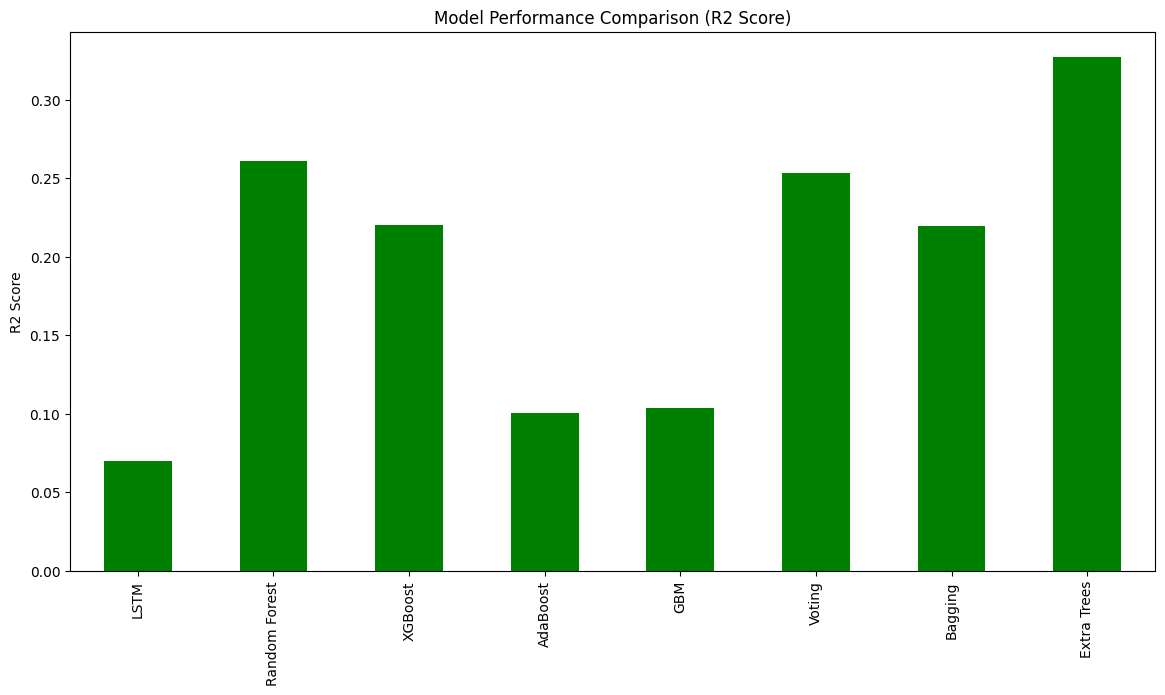

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.1 MB/s eta 0:00:00


Epoch 1/100
68/68 [==============================] - 3s 7ms/step - loss: 0.0669
Epoch 2/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0347
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0296
Epoch 4/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0292
Epoch 5/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 6/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0287
Epoch 8/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0265
Epoch 9/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0263
Epoch 10/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0262
Epoch 11/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 12/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0258
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


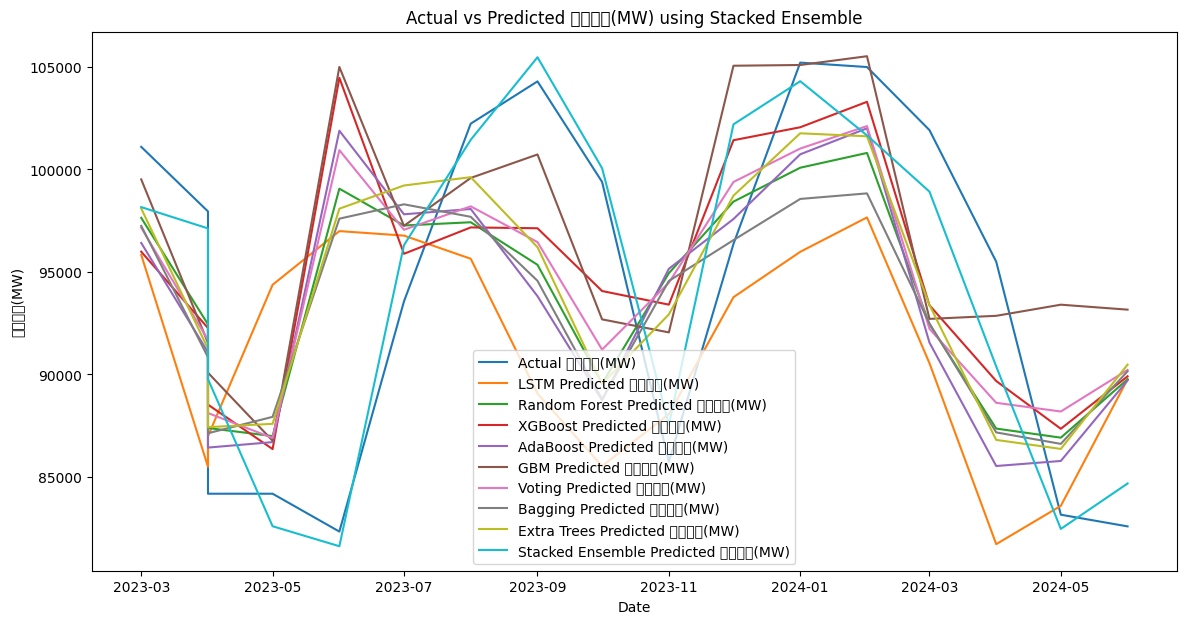

KeyError: 'Stacked Ensemble Residuals'

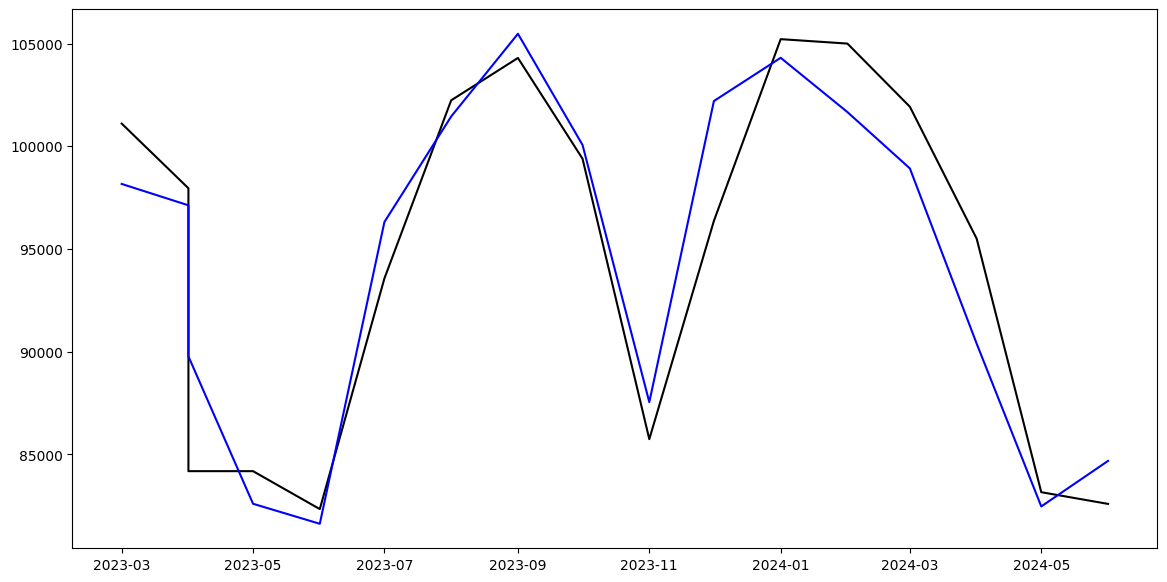

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()


Epoch 1/100
68/68 [==============================] - 3s 6ms/step - loss: 0.0661
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0368
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0282
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0272
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0261
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0257
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0255
Epoch 11/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0247
Epoch 12/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 13/100
68/68 [=================

1/1 [==============================] - 1s 650ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7077
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 300
[LightGBM] [Info] Start training from score 0.535564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


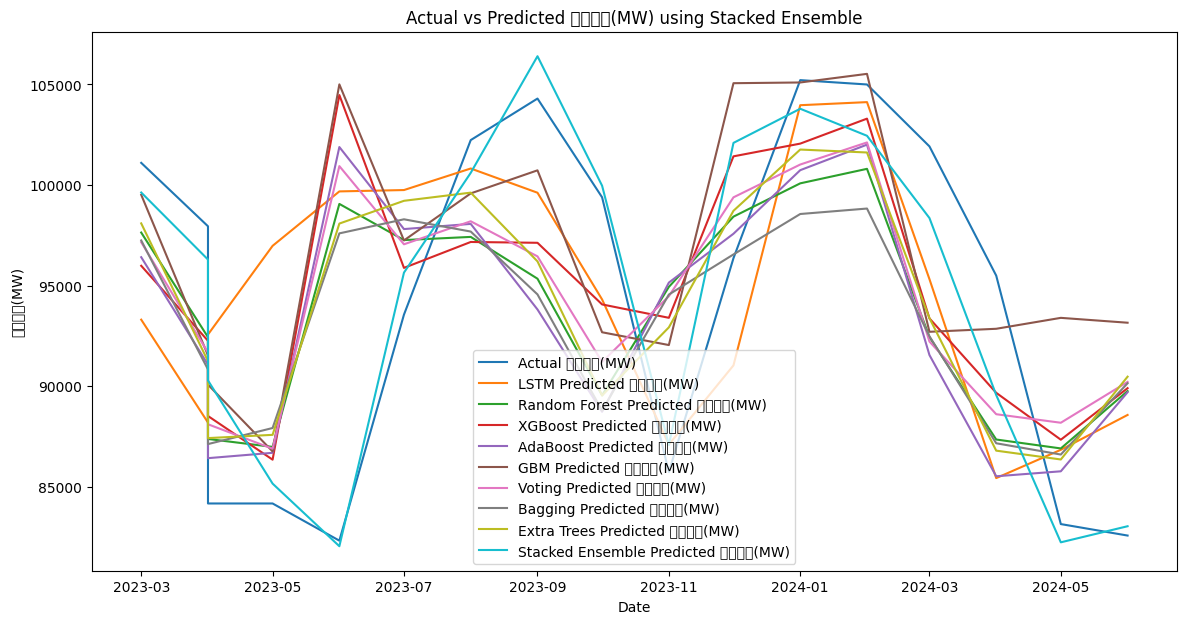

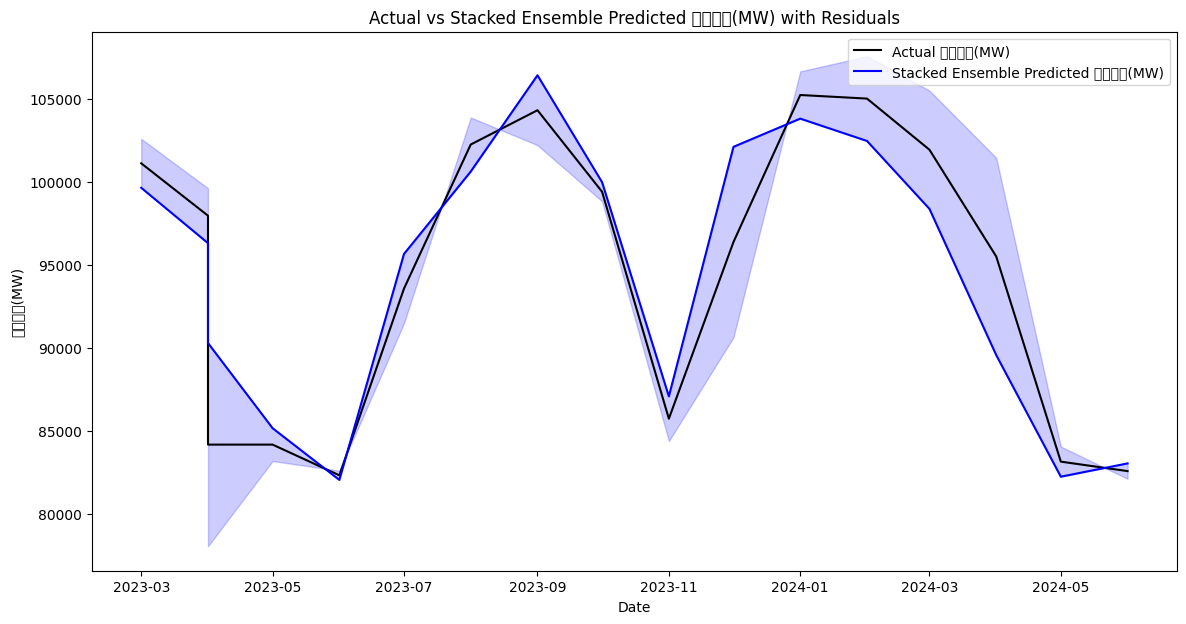

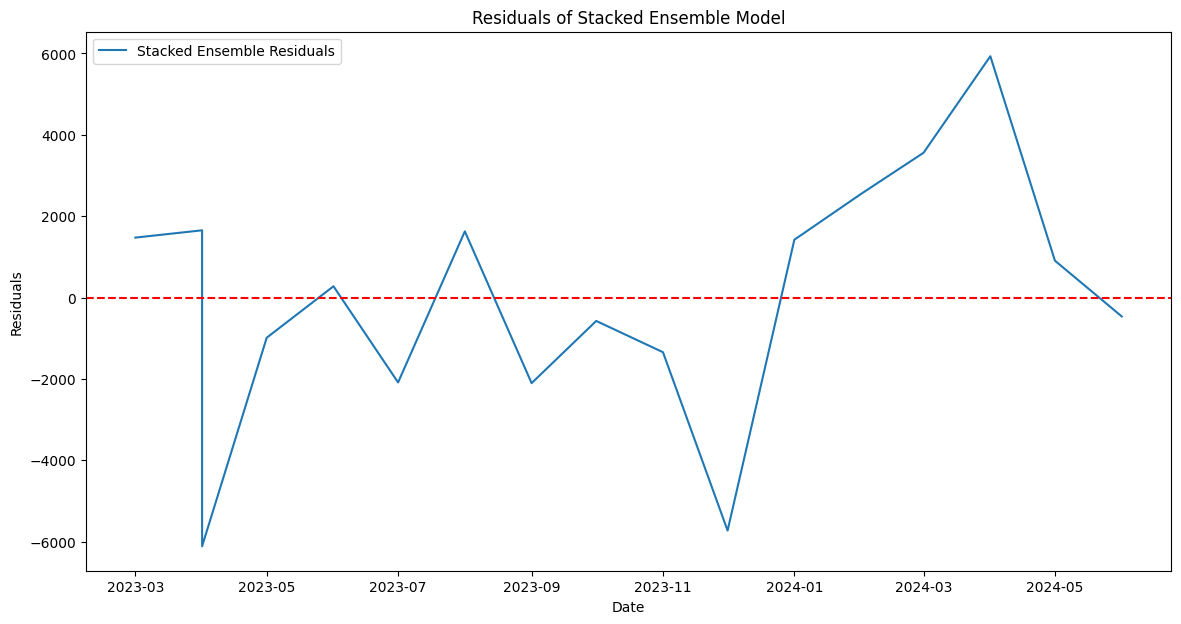

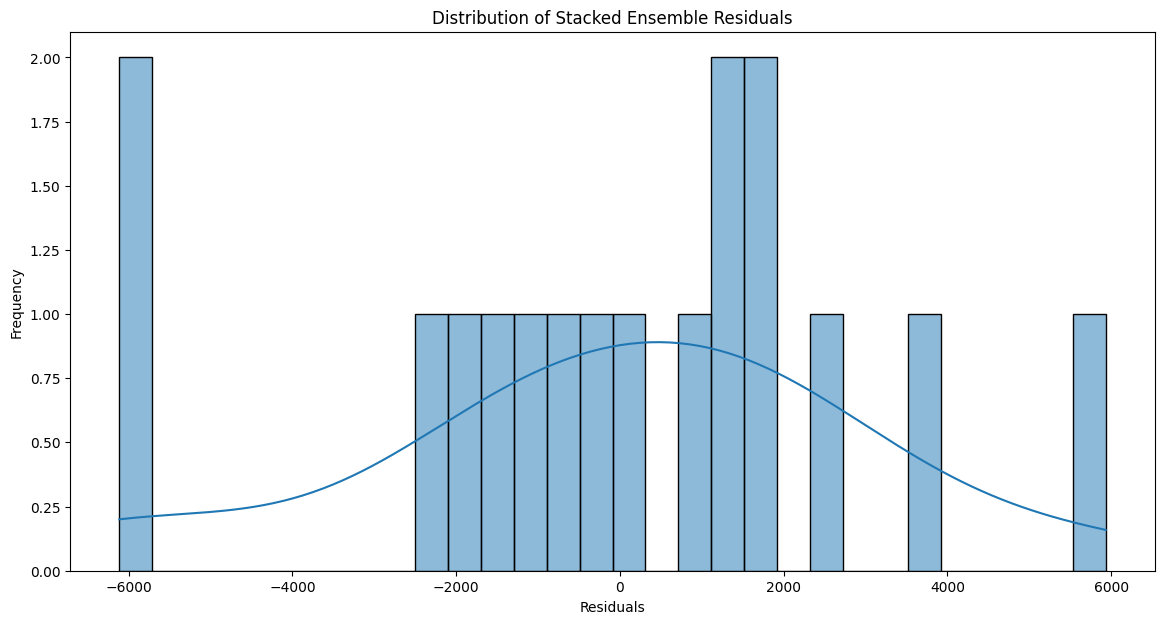

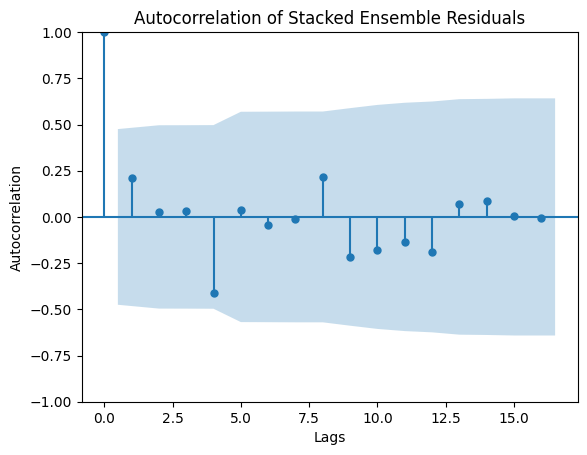

Stacked Ensemble Mean Squared Error: 8655178.459672548
Stacked Ensemble Mean Absolute Error: 2282.5622266876762
Stacked Ensemble R2 Score: 0.8802770430568283
LSTM Performance:
Mean Squared Error: 59176965.18833295
Mean Absolute Error: 6388.457720588235
R2 Score: 0.18143325544573485

Random Forest Performance:
Mean Squared Error: 53454113.497629374
Mean Absolute Error: 6362.446470588231
R2 Score: 0.2605947342934145

XGBoost Performance:
Mean Squared Error: 56373477.79350984
Mean Absolute Error: 6047.061956524849
R2 Score: 0.22021255990779787

AdaBoost Performance:
Mean Squared Error: 65023988.19615154
Mean Absolute Error: 6682.912408018128
R2 Score: 0.10055417397185806

GBM Performance:
Mean Squared Error: 64811587.84844251
Mean Absolute Error: 6123.123297681282
R2 Score: 0.1034922067116757

Voting Performance:
Mean Squared Error: 53966198.79122057
Mean Absolute Error: 6301.016540790798
R2 Score: 0.25351130258354204

Bagging Performance:
Mean Squared Error: 56417870.038811326
Mean Absol

<Figure size 1400x700 with 0 Axes>

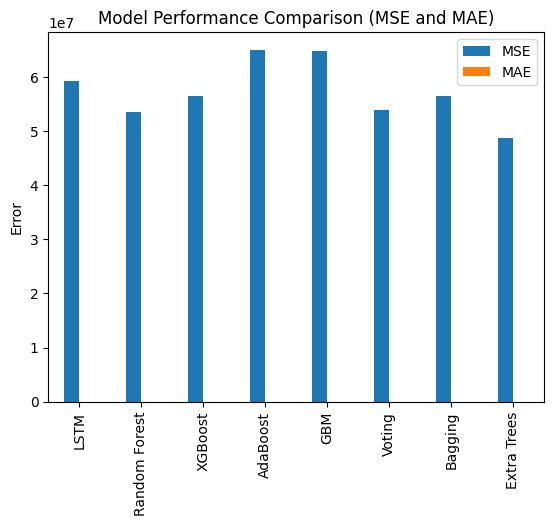

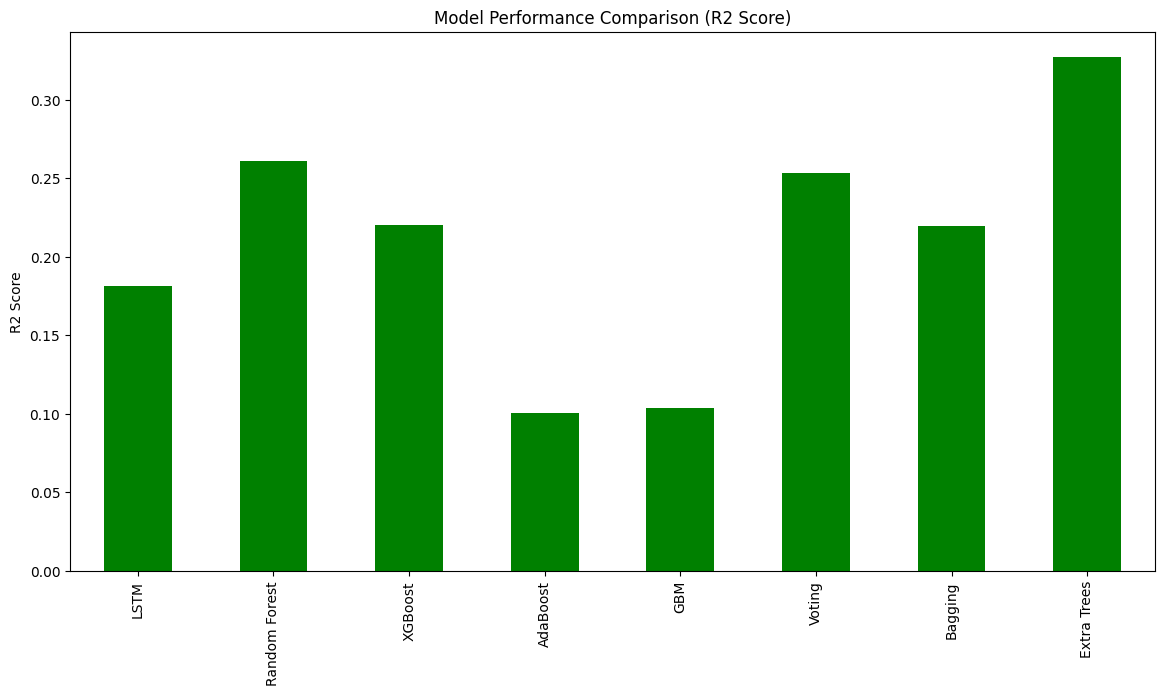

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()


Epoch 1/100
68/68 [==============================] - 4s 8ms/step - loss: 0.0640
Epoch 2/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0346
Epoch 3/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 4/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0299
Epoch 5/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0268
Epoch 6/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0266
Epoch 7/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0269
Epoch 8/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0270
Epoch 9/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0258
Epoch 10/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 11/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0255
Epoch 12/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


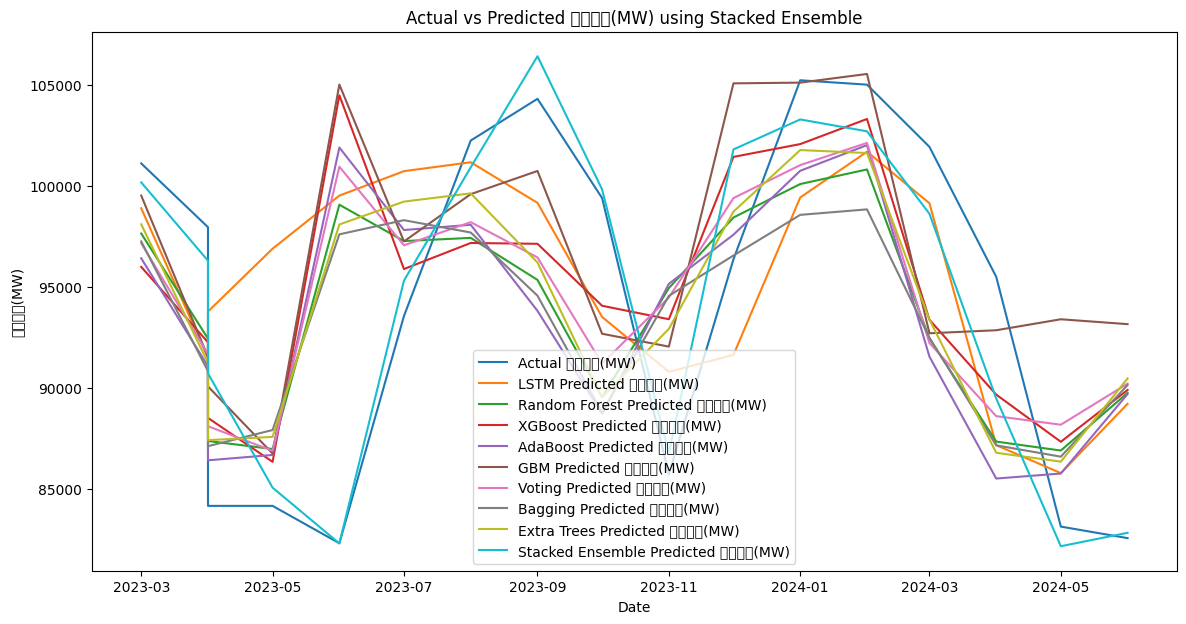

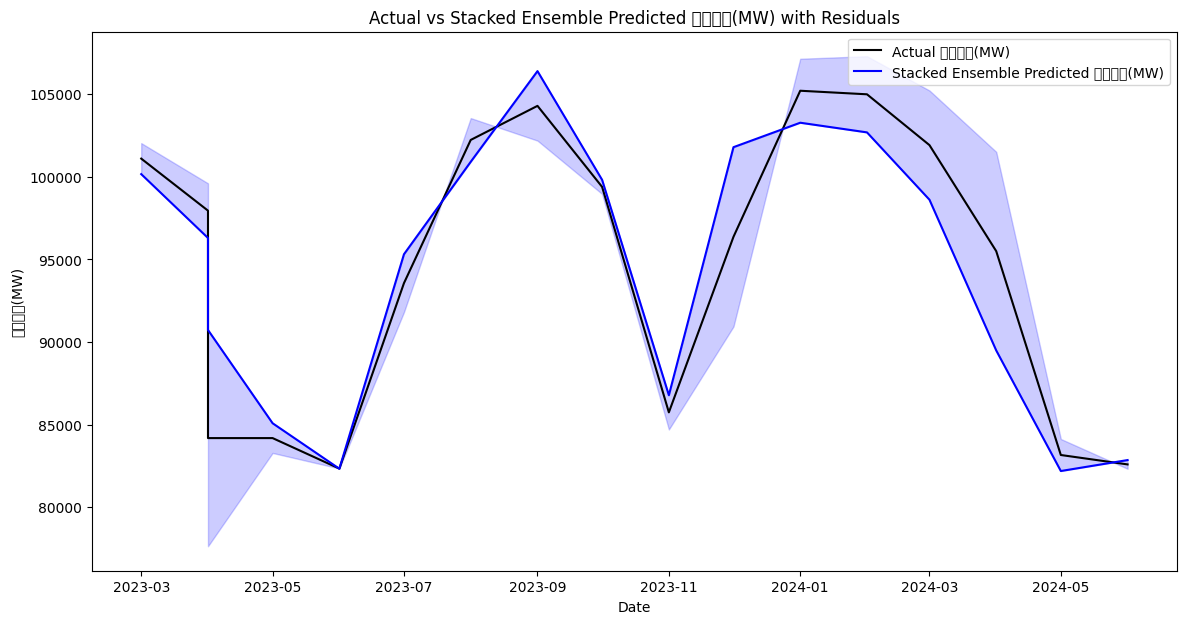

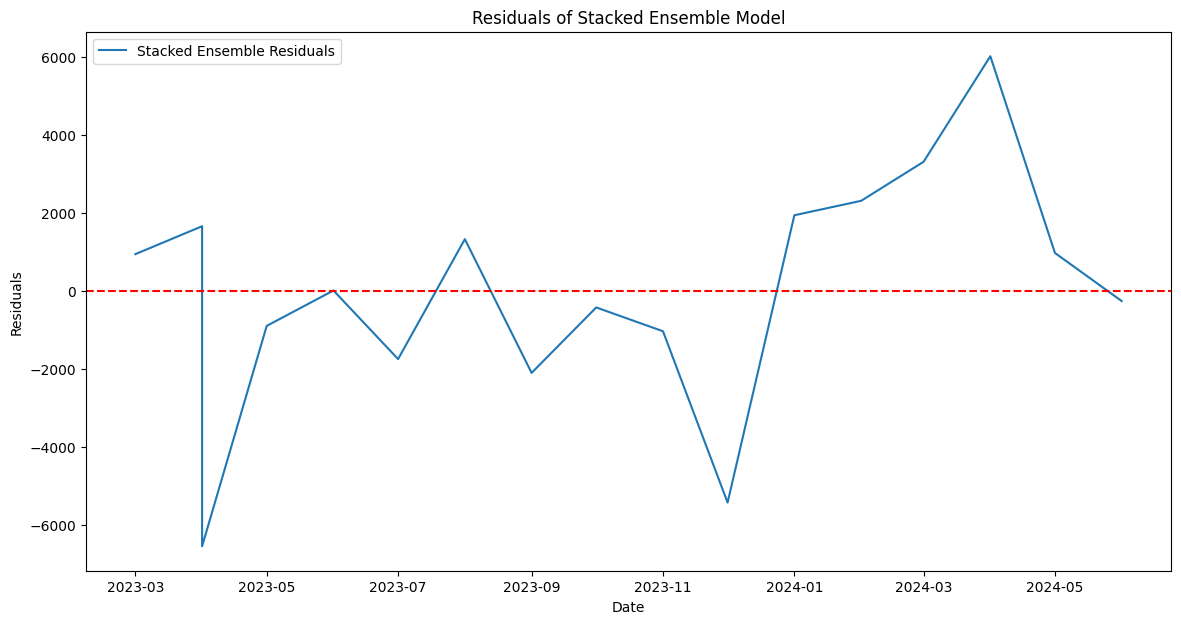

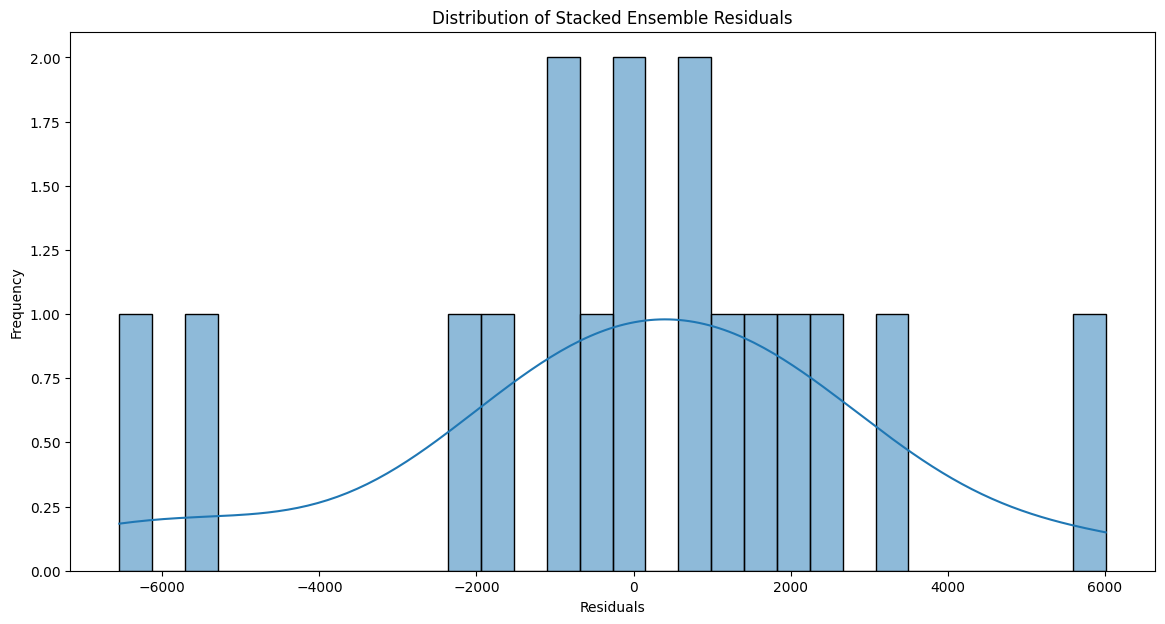

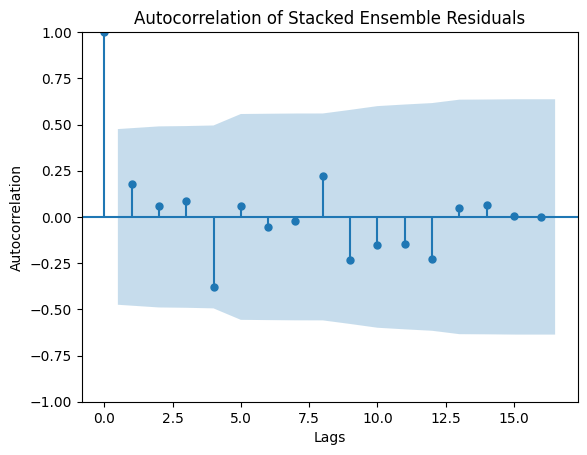

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


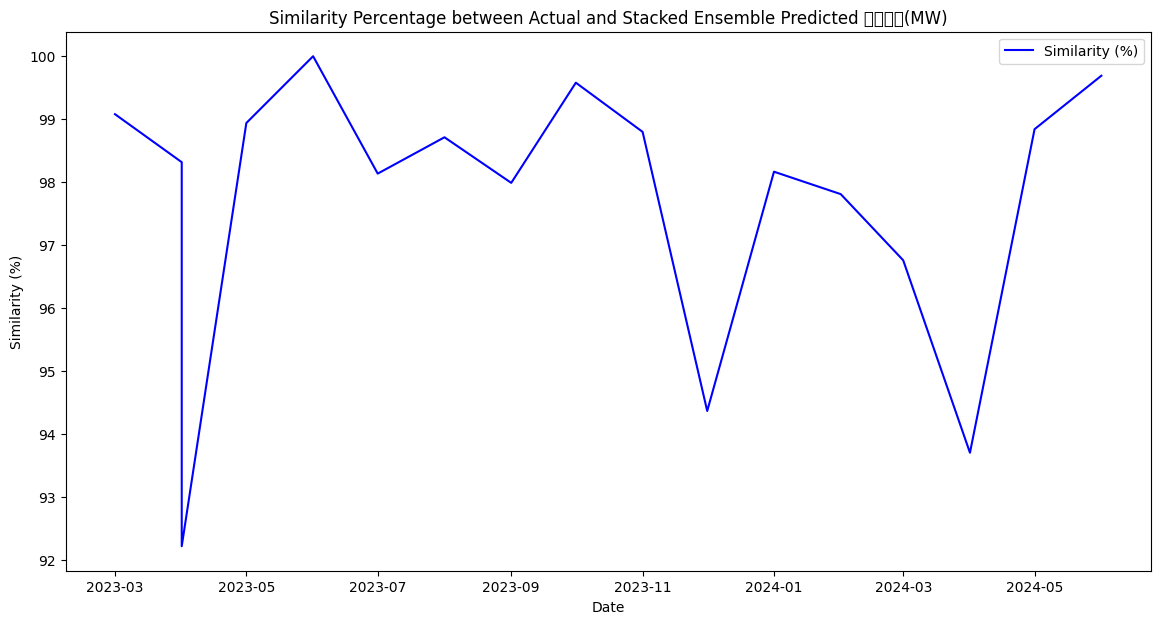

Stacked Ensemble Mean Squared Error: 8497403.959961489
Stacked Ensemble Mean Absolute Error: 2171.6178604725924
Stacked Ensemble R2 Score: 0.8824594624862657
LSTM Performance:
Mean Squared Error: 54678629.47502585
Mean Absolute Error: 6276.741727941177
R2 Score: 0.24365658861321438

Random Forest Performance:
Mean Squared Error: 53454113.497629374
Mean Absolute Error: 6362.446470588231
R2 Score: 0.2605947342934145

XGBoost Performance:
Mean Squared Error: 56373477.79350984
Mean Absolute Error: 6047.061956524849
R2 Score: 0.22021255990779787

AdaBoost Performance:
Mean Squared Error: 65023988.19615154
Mean Absolute Error: 6682.912408018128
R2 Score: 0.10055417397185806

GBM Performance:
Mean Squared Error: 64811587.84844251
Mean Absolute Error: 6123.123297681282
R2 Score: 0.1034922067116757

Voting Performance:
Mean Squared Error: 53966198.79122057
Mean Absolute Error: 6301.016540790798
R2 Score: 0.25351130258354204

Bagging Performance:
Mean Squared Error: 56417870.038811326
Mean Absol

<Figure size 1400x700 with 0 Axes>

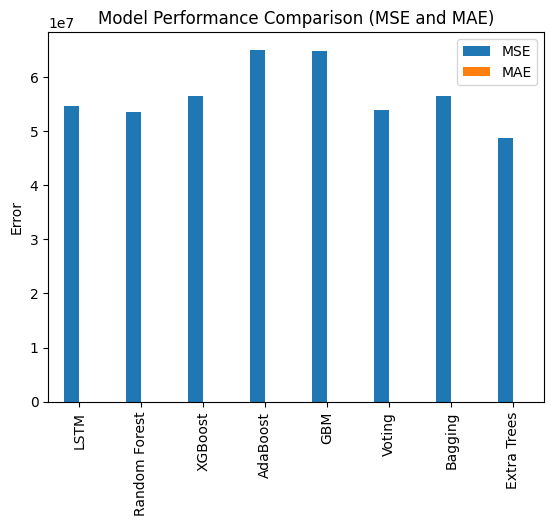

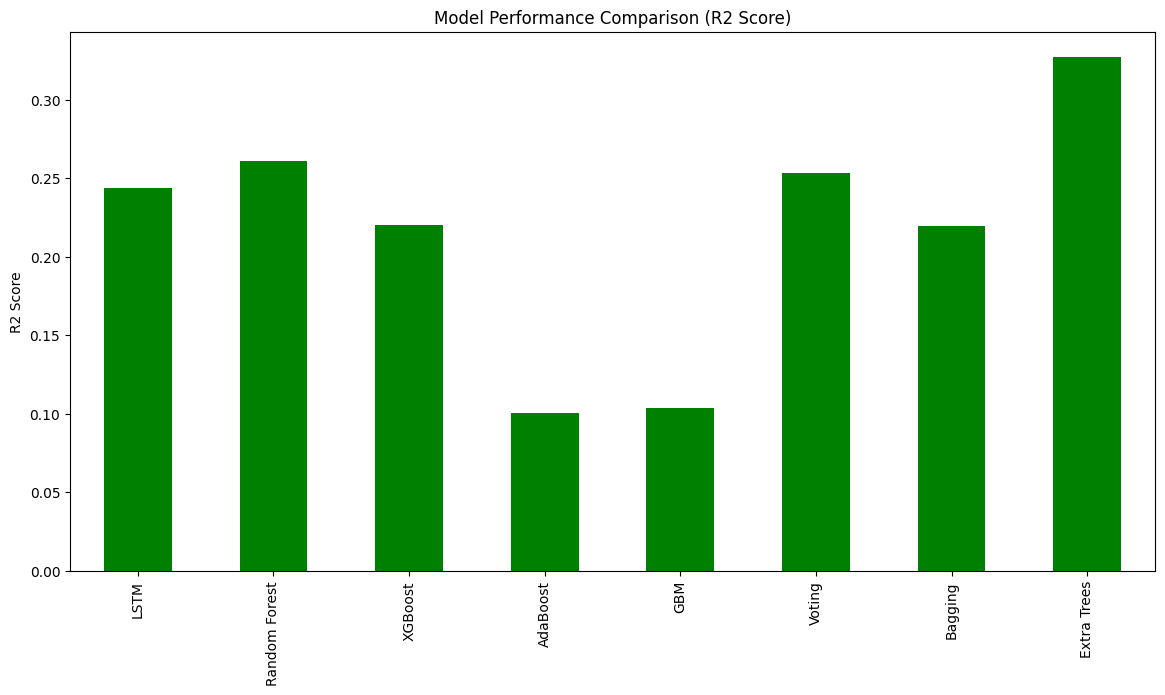

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()



In [2]:
import pandas as pd

# 파일 경로
file_path = 'HOME_전력수급_최대전력수급_일별.csv'

# 데이터 로드 (encoding 옵션 추가)
daily_data = pd.read_csv(file_path, encoding='cp949')

# 데이터 확인
daily_data_head = daily_data.head()
daily_data_info = daily_data.info()

daily_data_head, daily_data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3497 entries, 0 to 3496
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   년          3497 non-null   int64  
 1   월          3497 non-null   int64  
 2   일          3497 non-null   int64  
 3   설비용량(MW)   3497 non-null   int64  
 4   공급능력(MW)   3497 non-null   int64  
 5   최대전력(MW)   3497 non-null   int64  
 6   공급예비력(MW)  3497 non-null   int64  
 7   공급예비율(%)   3497 non-null   float64
 8   최대전력기준일시   3497 non-null   object 
dtypes: float64(1), int64(7), object(1)
memory usage: 246.0+ KB


(      년  월   일  설비용량(MW)  공급능력(MW)  최대전력(MW)  공급예비력(MW)  공급예비율(%)  \
 0  2024  7  18    148917     98615     84567      14048      16.6   
 1  2024  7  17    148917     99597     84204      15393      18.3   
 2  2024  7  16    148912     98716     83678      15038      18.0   
 3  2024  7  15    148912    100094     82759      17335      20.9   
 4  2024  7  14    148912     95453     69336      26117      37.7   
 
             최대전력기준일시  
 0  2024/07/18(11:00)  
 1  2024/07/17(17:00)  
 2  2024/07/16(15:00)  
 3  2024/07/15(17:00)  
 4  2024/07/14(20:00)  ,
 None)

In [5]:
# 데이터프레임 열 이름 확인
print(daily_data.columns)


Index(['년', '월', '일', '설비용량(MW)', '공급능력(MW)', '최대전력(MW)', '공급예비력(MW)',
       '공급예비율(%)', '최대전력기준일시'],
      dtype='object')


Epoch 1/100
68/68 [==============================] - 3s 6ms/step - loss: 0.6741
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4974
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4814
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 0.4731
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4506
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4394
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4296
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3976
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3736
Epoch 10/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3623
Epoch 11/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3541
Epoch 12/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3059
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


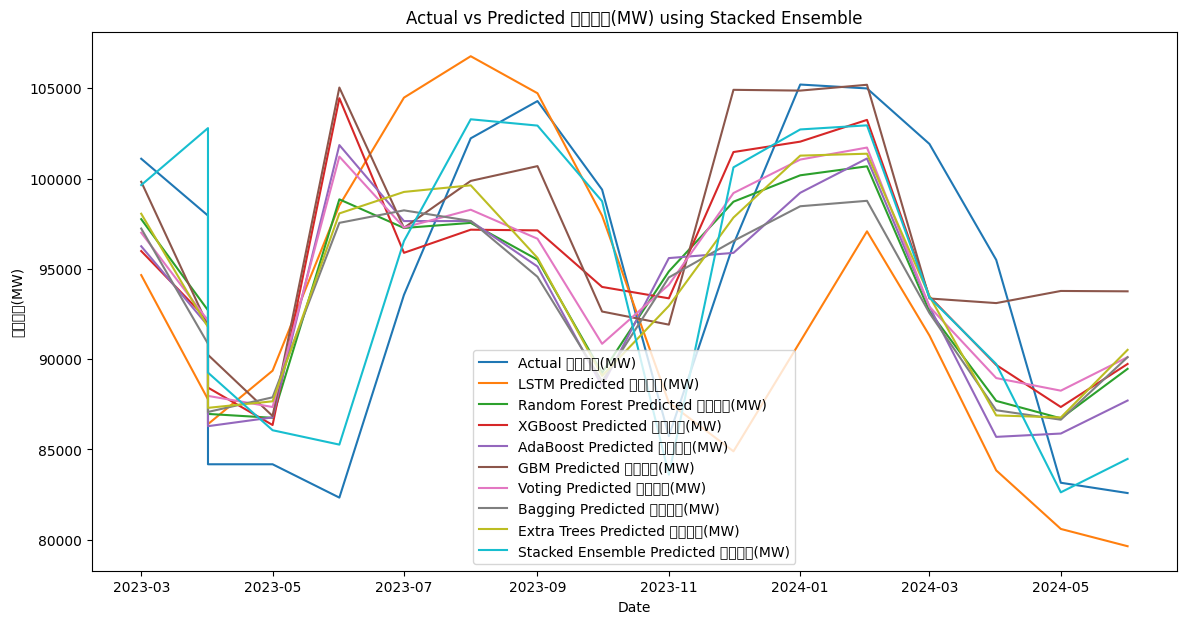

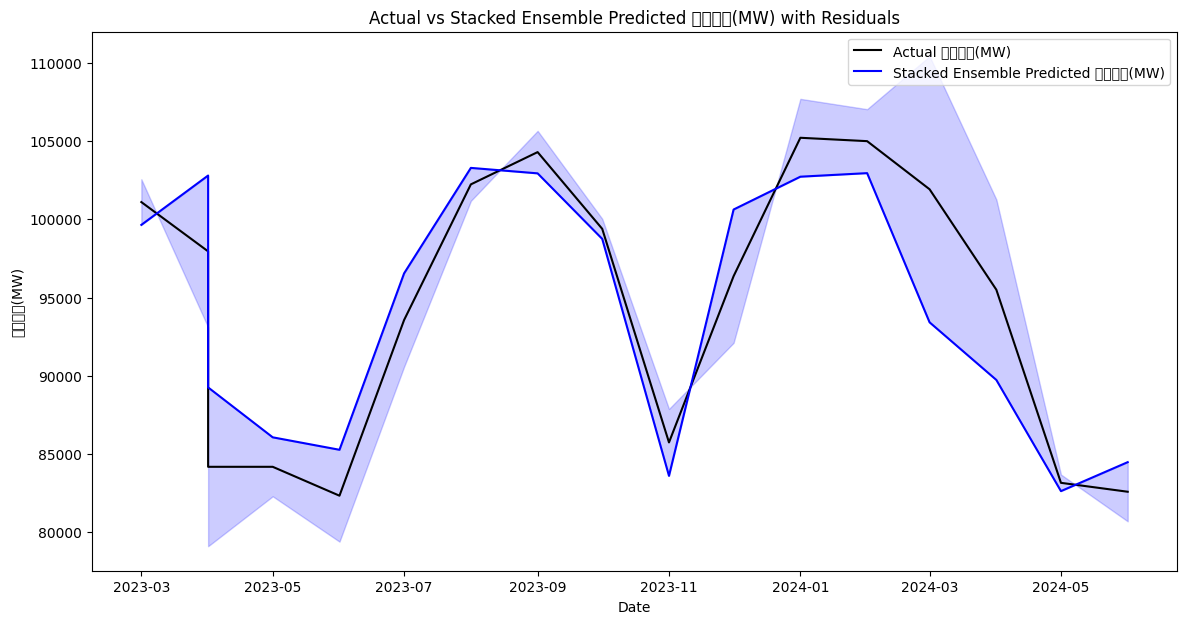

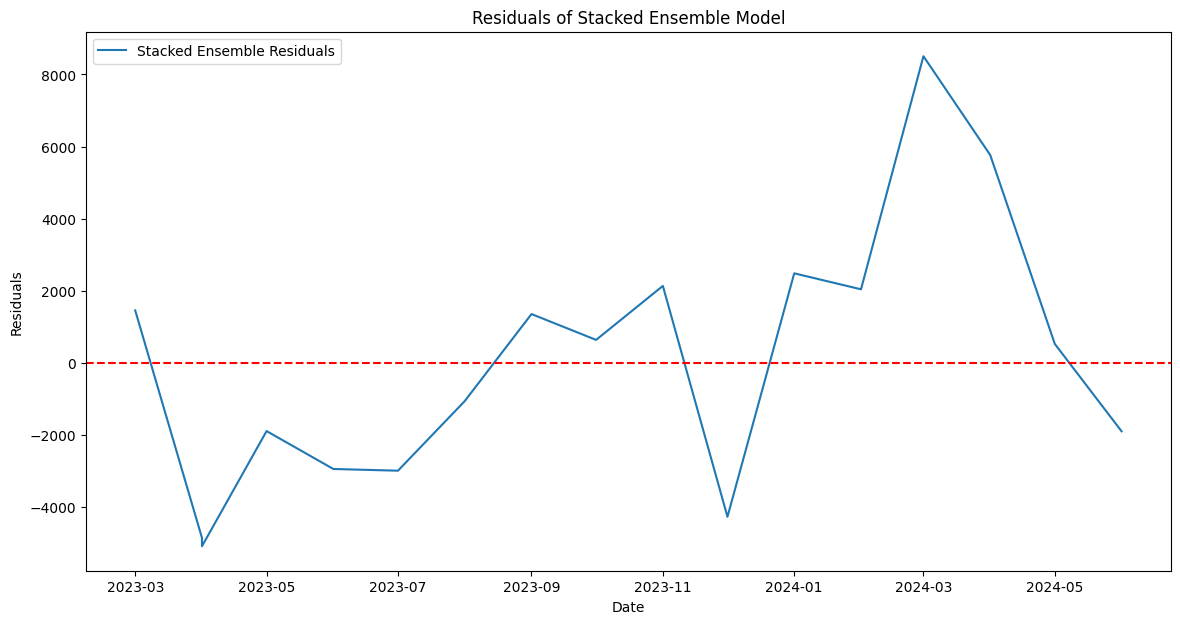

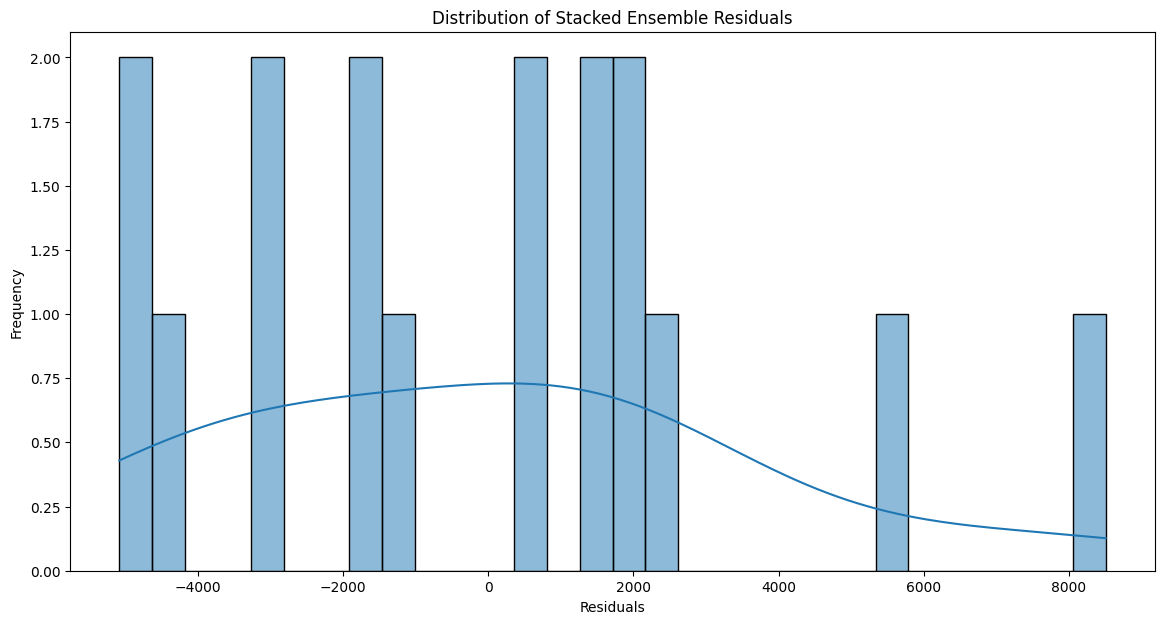

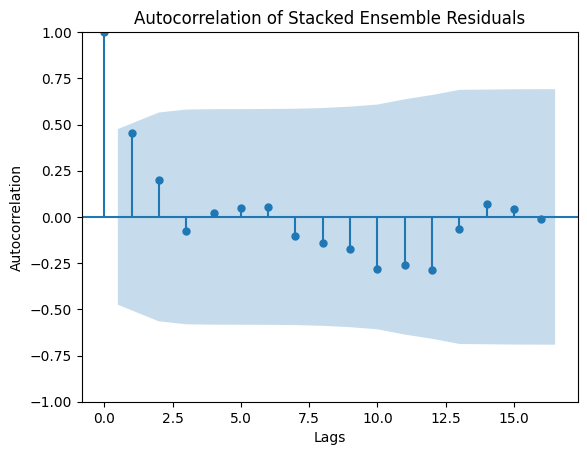

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


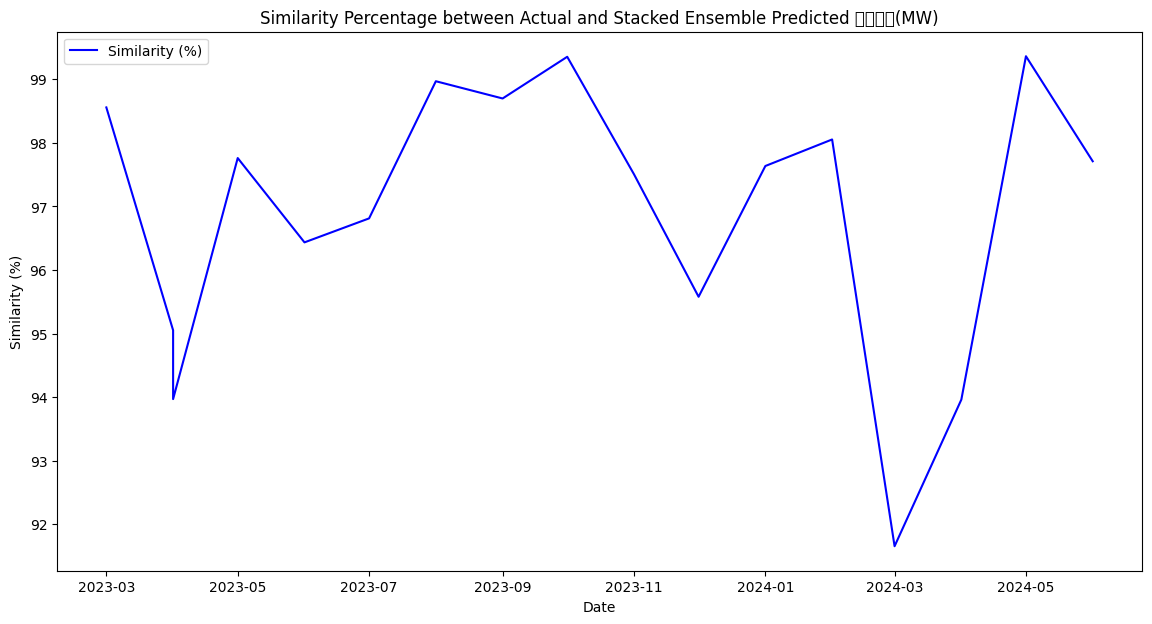

Stacked Ensemble Mean Squared Error: 12847155.11461114
Stacked Ensemble Mean Absolute Error: 2933.452320423234
Stacked Ensemble R2 Score: 0.8222914286752872
LSTM Performance:
Mean Squared Error: 73241144.6318862
Mean Absolute Error: 7106.193014705882
R2 Score: -0.013109833158040818

Random Forest Performance:
Mean Squared Error: 51860874.97037647
Mean Absolute Error: 6244.1741176470605
R2 Score: 0.28263324320311045

XGBoost Performance:
Mean Squared Error: 56155956.14028893
Mean Absolute Error: 6038.322473440558
R2 Score: 0.223221433224982

AdaBoost Performance:
Mean Squared Error: 61939062.09540724
Mean Absolute Error: 6516.960455456693
R2 Score: 0.14322648586619302

GBM Performance:
Mean Squared Error: 64978140.85368196
Mean Absolute Error: 6074.056285181029
R2 Score: 0.10118835840075457

Voting Performance:
Mean Squared Error: 53270559.39752008
Mean Absolute Error: 6262.019644012679
R2 Score: 0.263133750643744

Bagging Performance:
Mean Squared Error: 56292061.09513154
Mean Absolute

<Figure size 1400x700 with 0 Axes>

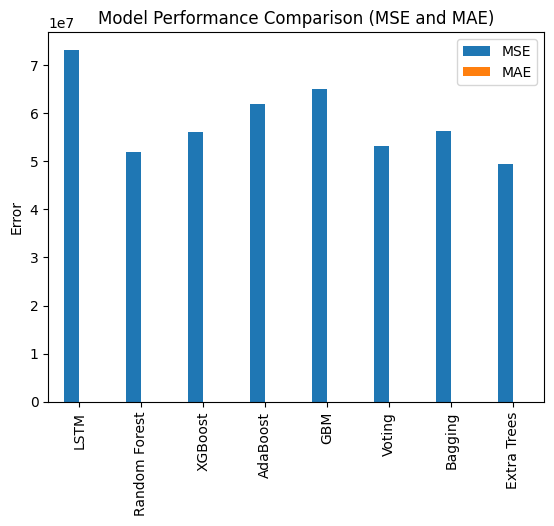

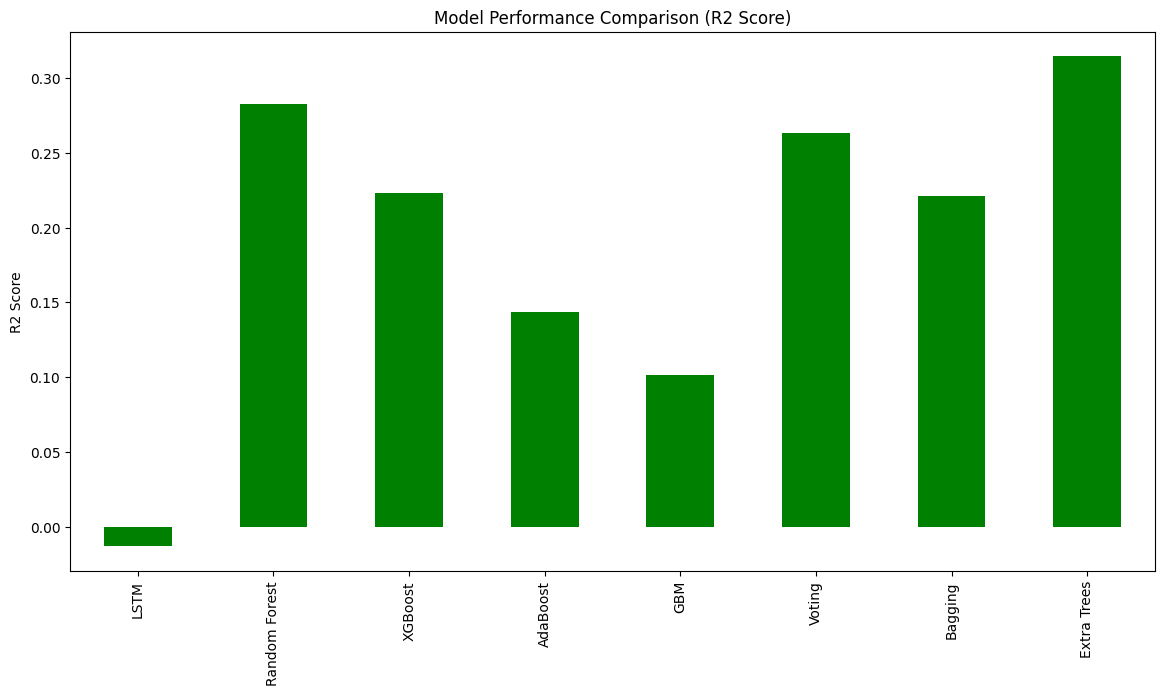

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화 (표준정규화)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()


Epoch 1/100
68/68 [==============================] - 4s 6ms/step - loss: 0.6634
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.5397
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4884
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4750
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4610
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4496
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4411
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4190
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3842
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3756
Epoch 11/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3608
Epoch 12/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3343
Epoch 13/100
68/68 [=================

1/1 [==============================] - 1s 631ms/step
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7192
[LightGBM] [Info] Number of data points in the train set: 68, number of used features: 300
[LightGBM] [Info] Start training from score 0.210571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


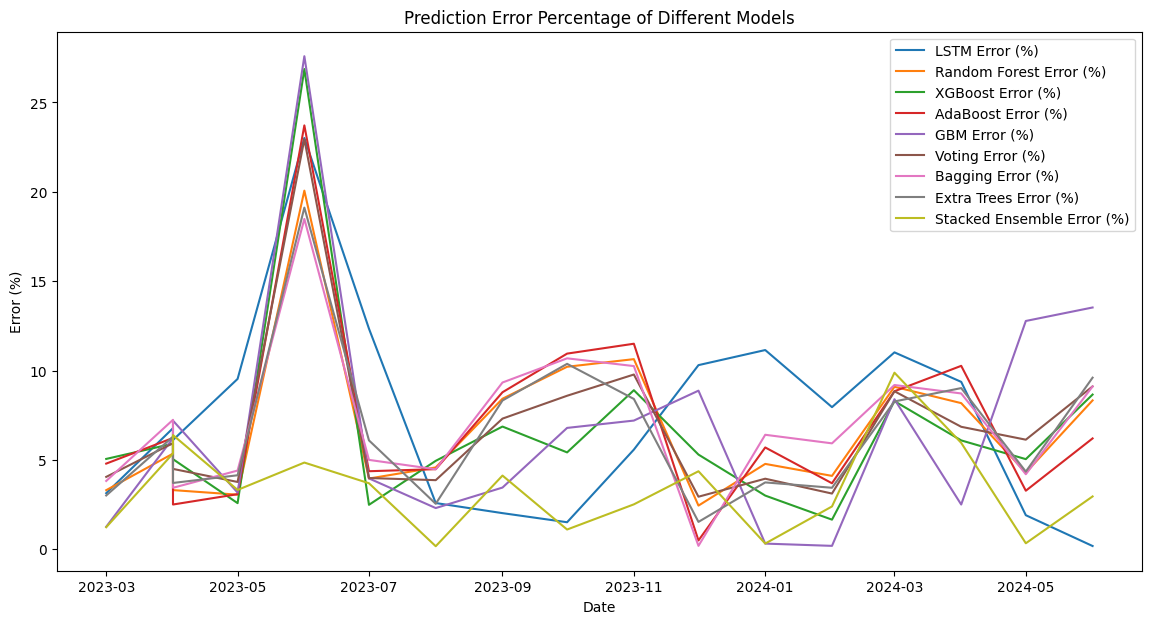

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


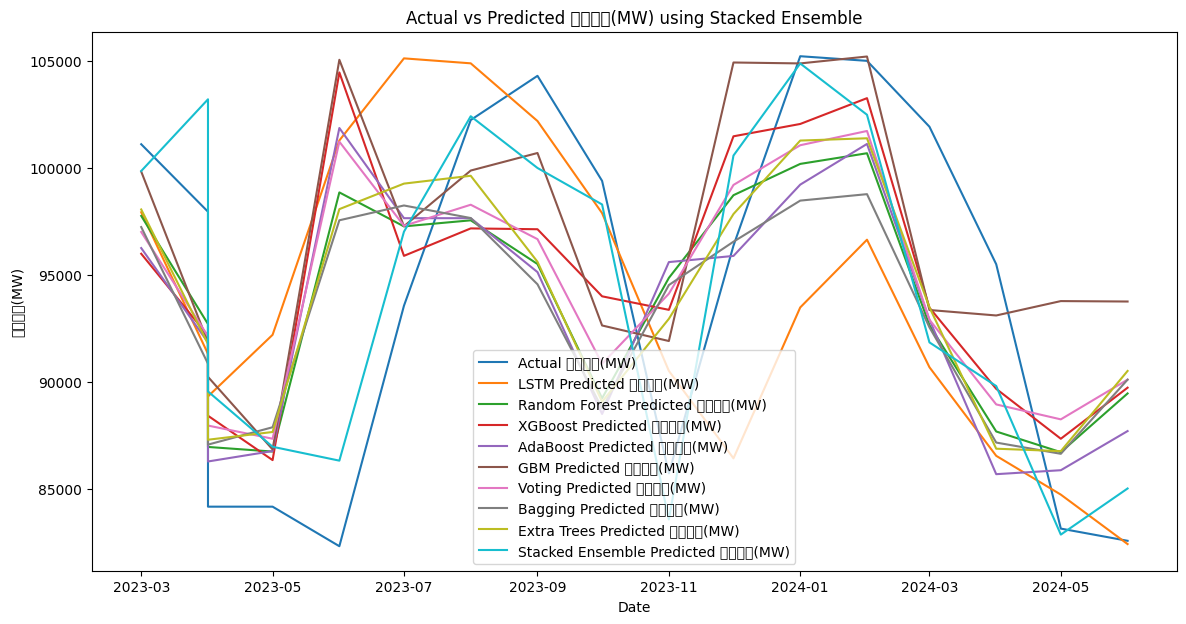

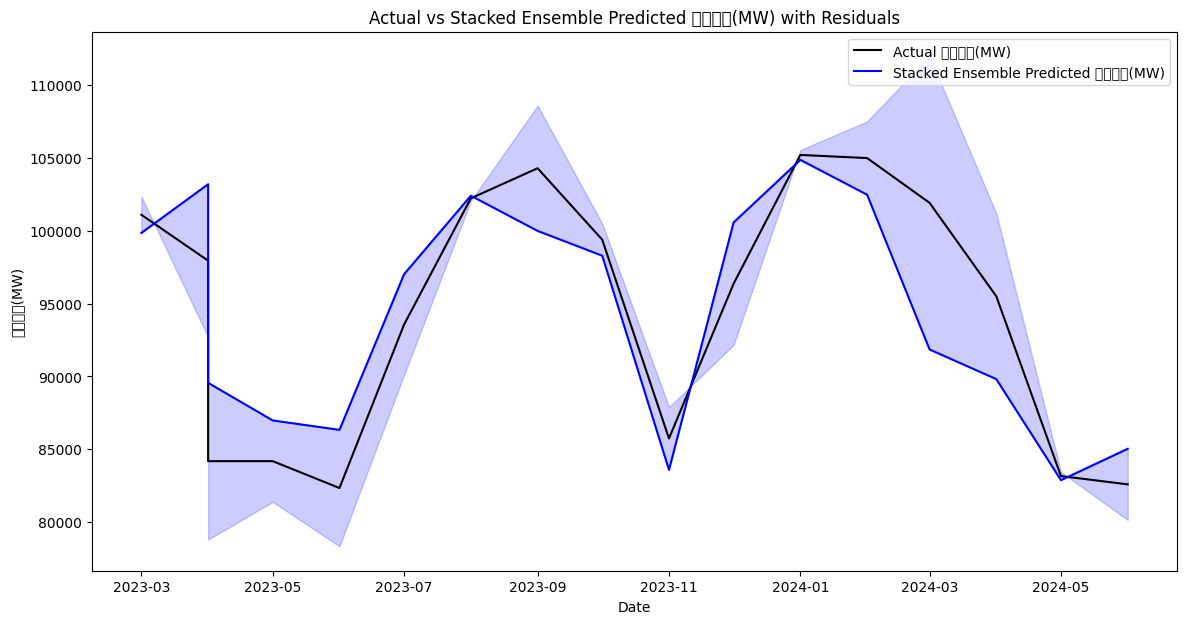

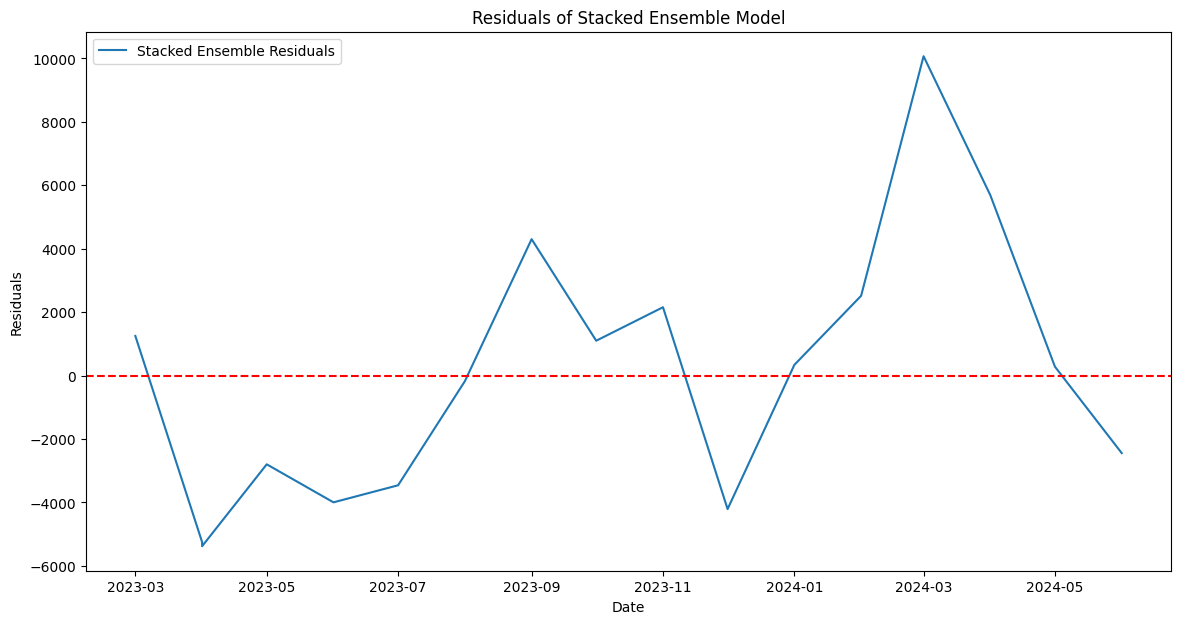

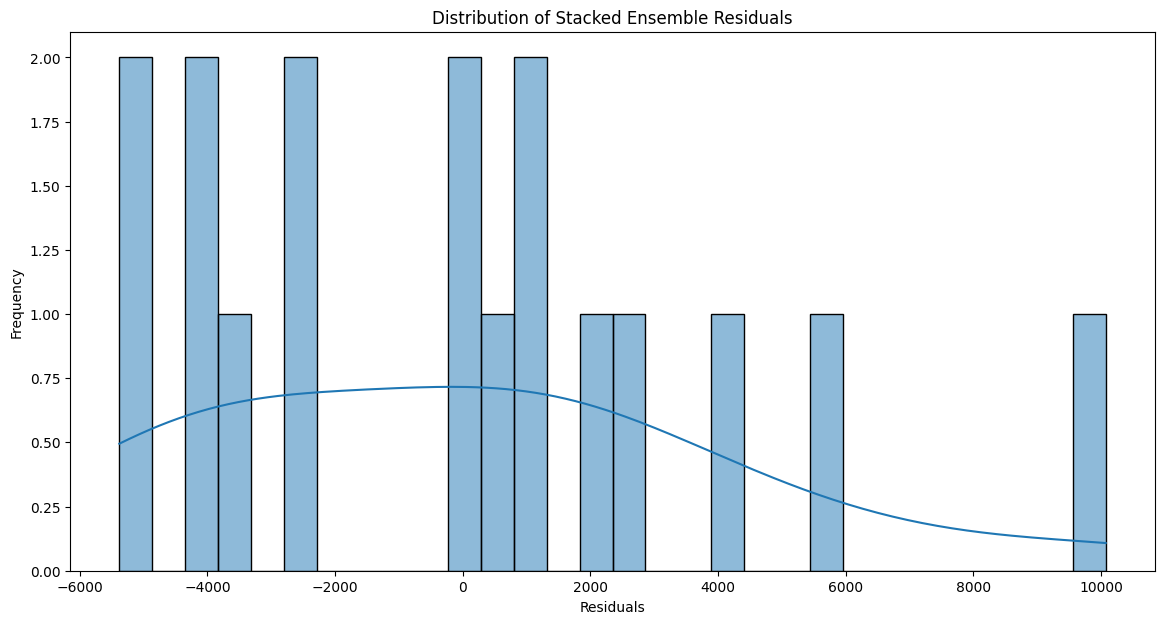

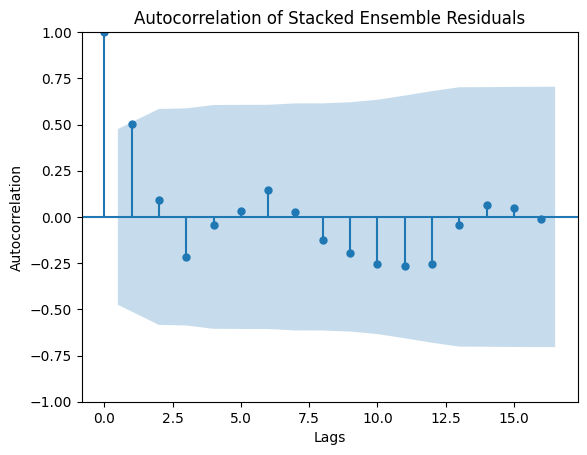

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


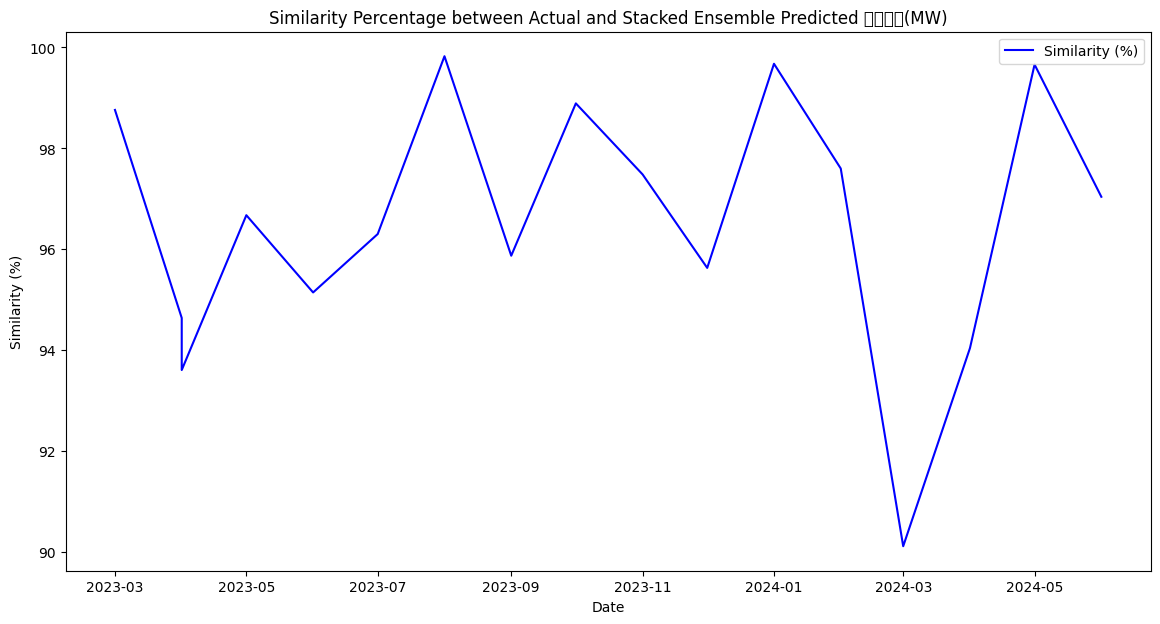

Stacked Ensemble Mean Squared Error: 16601880.519037766
Stacked Ensemble Mean Absolute Error: 3259.860561479535
Stacked Ensemble R2 Score: 0.7703541023657139
LSTM Performance:
Mean Squared Error: 69929090.90527344
Mean Absolute Error: 6850.689338235294
R2 Score: 0.0327042268930946

Random Forest Performance:
Mean Squared Error: 51860874.97037647
Mean Absolute Error: 6244.1741176470605
R2 Score: 0.28263324320311045

XGBoost Performance:
Mean Squared Error: 56155956.14028893
Mean Absolute Error: 6038.322473440558
R2 Score: 0.223221433224982

AdaBoost Performance:
Mean Squared Error: 61939062.09540724
Mean Absolute Error: 6516.960455456693
R2 Score: 0.14322648586619302

GBM Performance:
Mean Squared Error: 64978140.85368196
Mean Absolute Error: 6074.056285181029
R2 Score: 0.10118835840075457

Voting Performance:
Mean Squared Error: 53270559.39752008
Mean Absolute Error: 6262.019644012679
R2 Score: 0.263133750643744

Bagging Performance:
Mean Squared Error: 56292061.09513154
Mean Absolute 

<Figure size 1400x700 with 0 Axes>

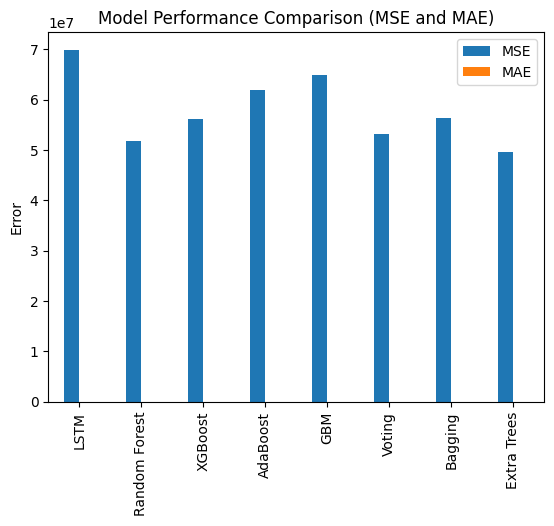

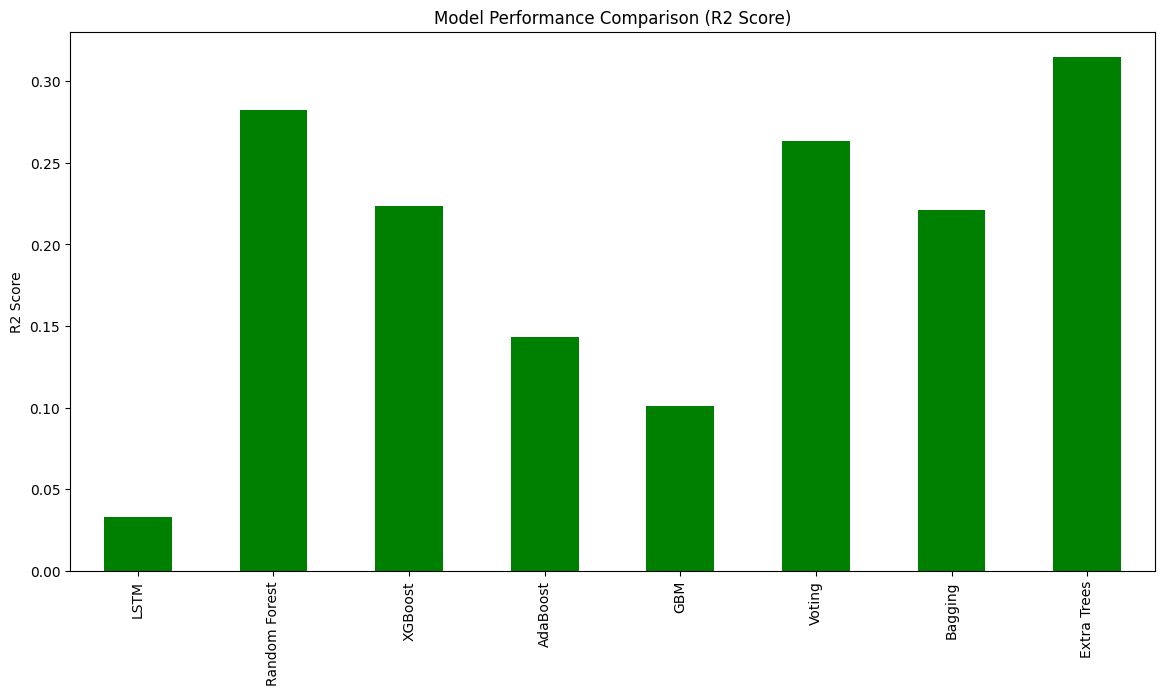

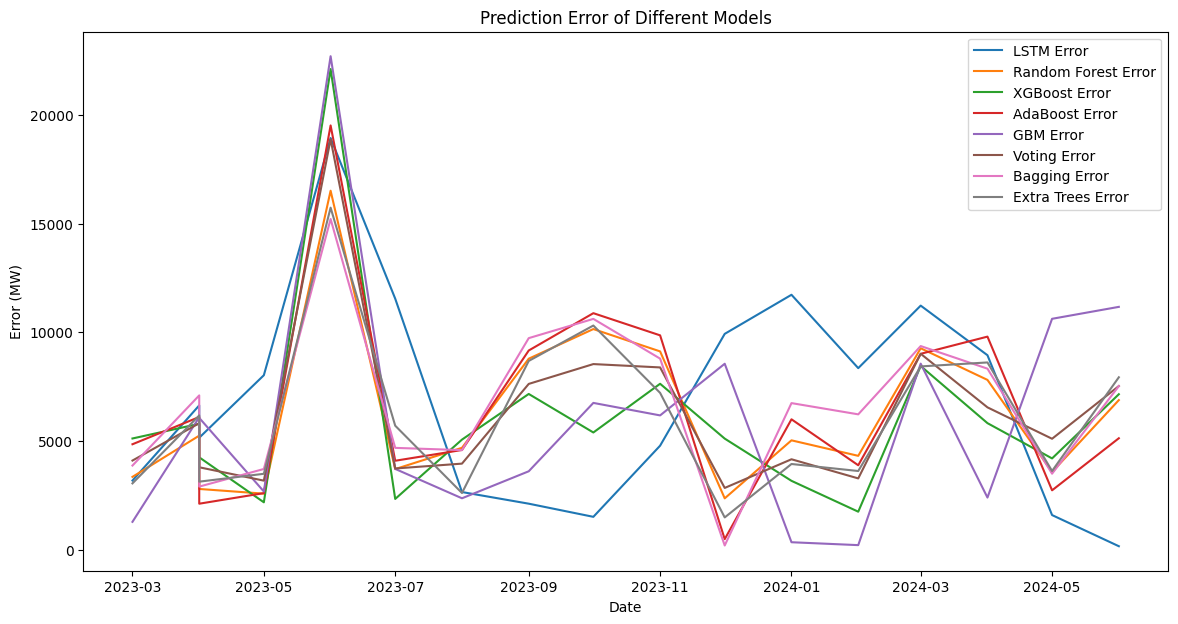

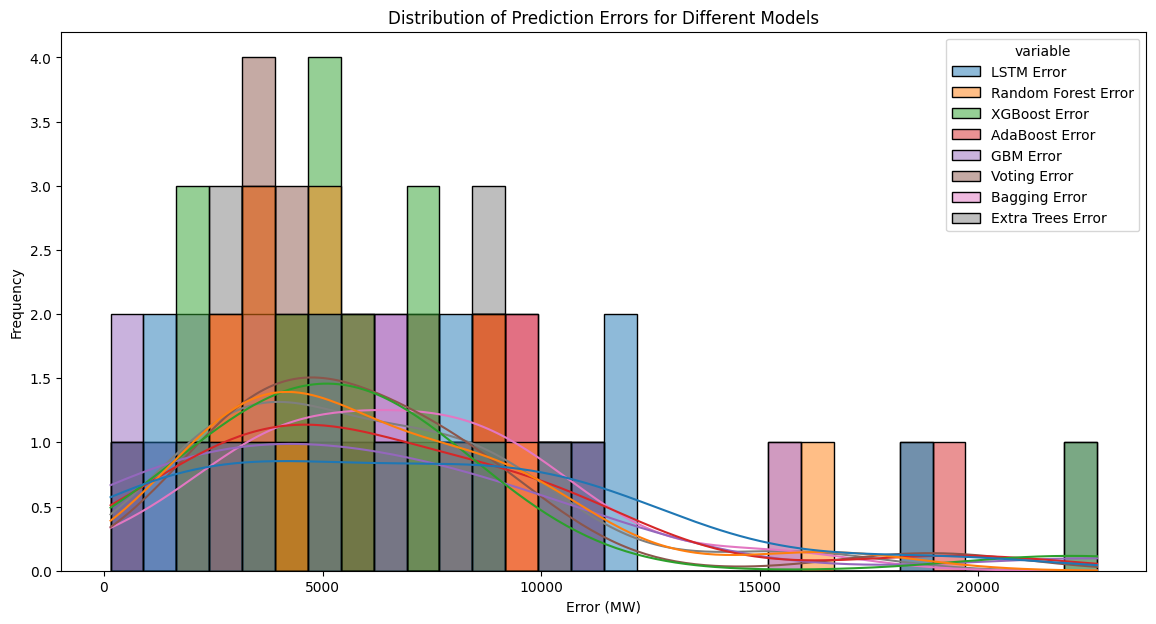

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화 (표준정규화)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)


# 메타 모델의 예측값을 데이터프레임에 추가한 후
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 실측값과의 차이를 백분율로 계산하여 데이터프레임에 추가
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    comparison_df[f'{model} Error (%)'] = 100 * np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)']

# 백분율 차이 시각화
plt.figure(figsize=(14, 7))
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error (%)'], label=f'{model} Error (%)')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.title('Prediction Error Percentage of Different Models')
plt.legend()
plt.show()


# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()

# 예측값과 실제값의 차이 시각화
plt.figure(figsize=(14, 7))
for model in models.keys():
    comparison_df[f'{model} Error'] = np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)'])
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error'], label=f'{model} Error')
plt.xlabel('Date')
plt.ylabel('Error (MW)')
plt.title('Prediction Error of Different Models')
plt.legend()
plt.show()

# 예측값과 실제값의 차이 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df[[f'{model} Error' for model in models.keys()]].melt(), x='value', hue='variable', kde=True, bins=30)
plt.xlabel('Error (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors for Different Models')
plt.show()



Epoch 1/100
68/68 [==============================] - 3s 6ms/step - loss: 0.7136
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4988
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4765
Epoch 4/100
68/68 [==============================] - 0s 5ms/step - loss: 0.4640
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4508
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4363
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4358
Epoch 8/100
68/68 [==============================] - 0s 7ms/step - loss: 0.3985
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3697
Epoch 10/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3649
Epoch 11/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3269
Epoch 12/100
68/68 [==============================] - 0s 5ms/step - loss: 0.3280
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


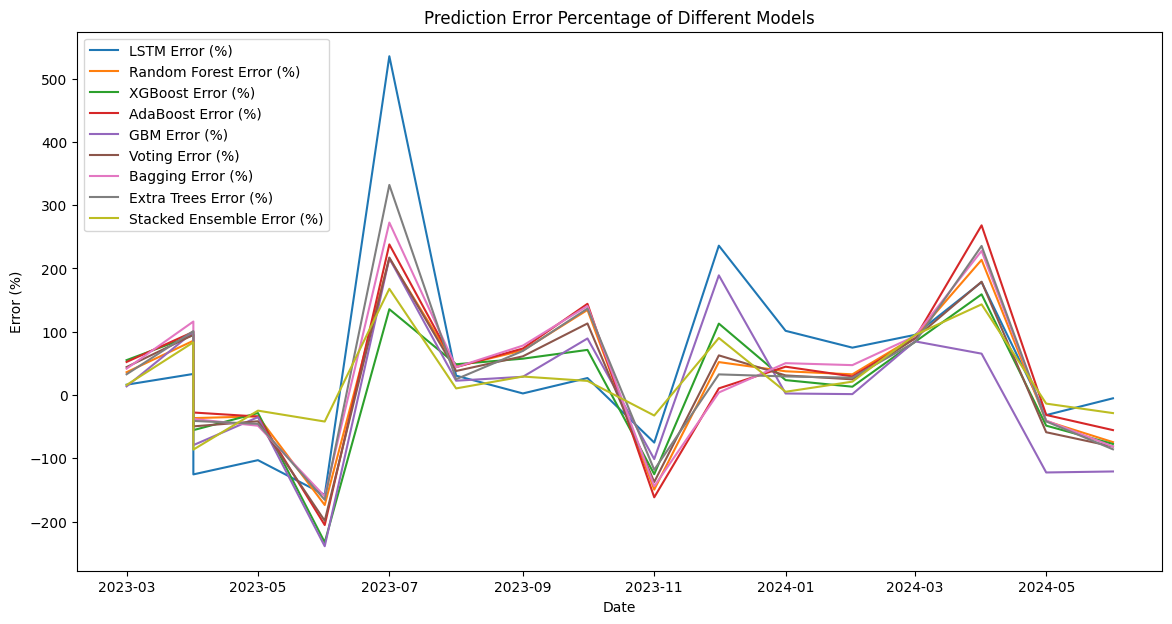

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


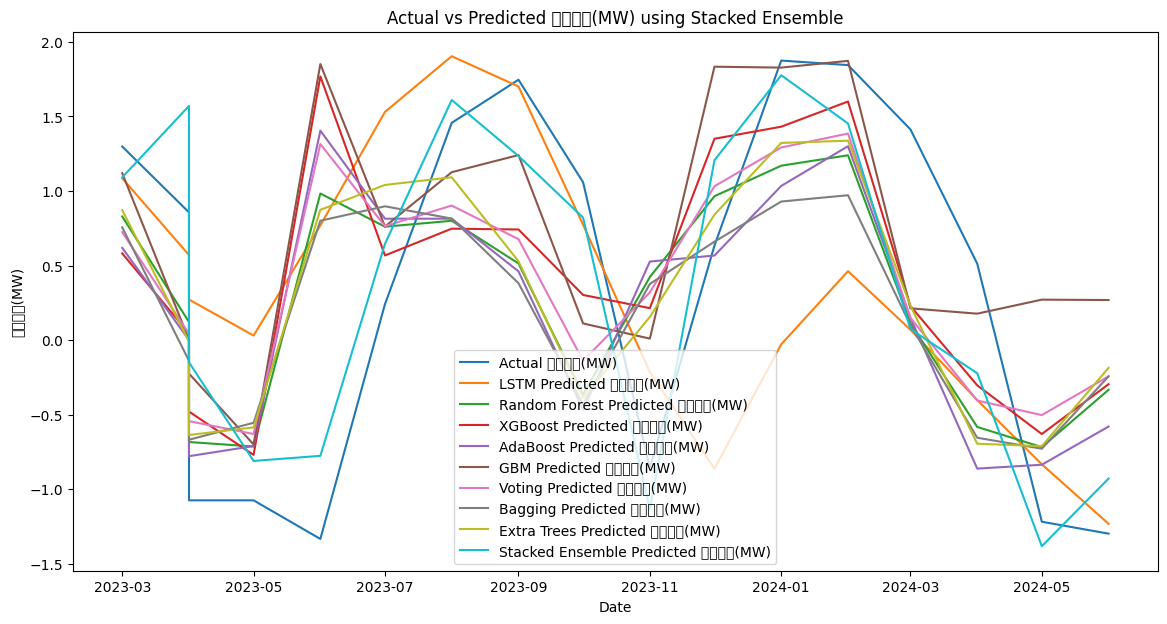

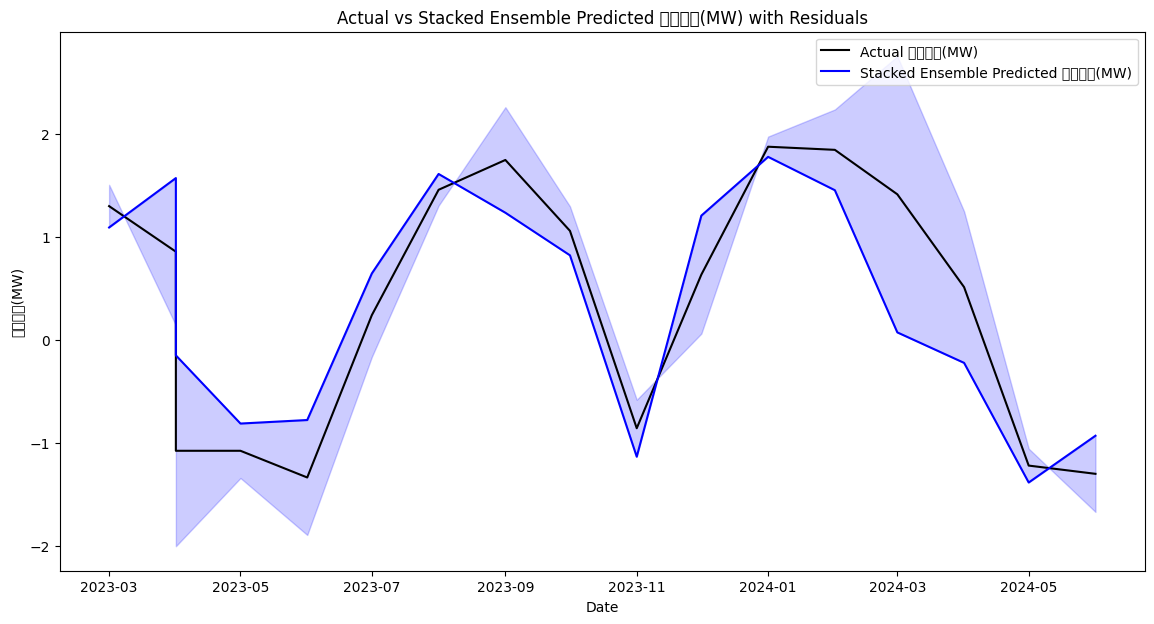

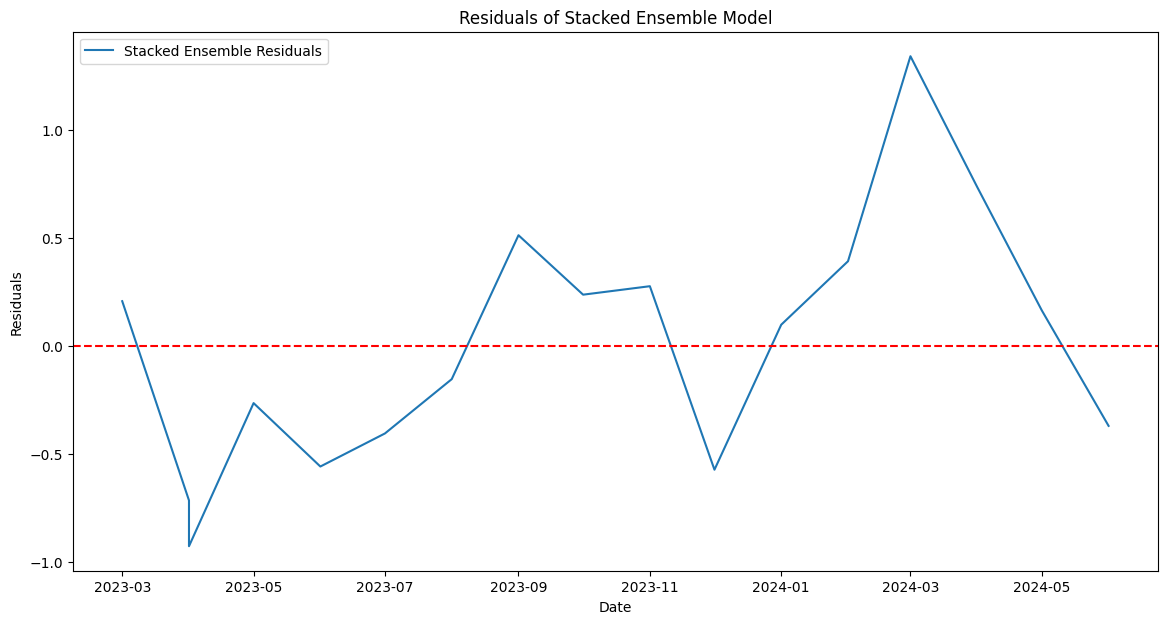

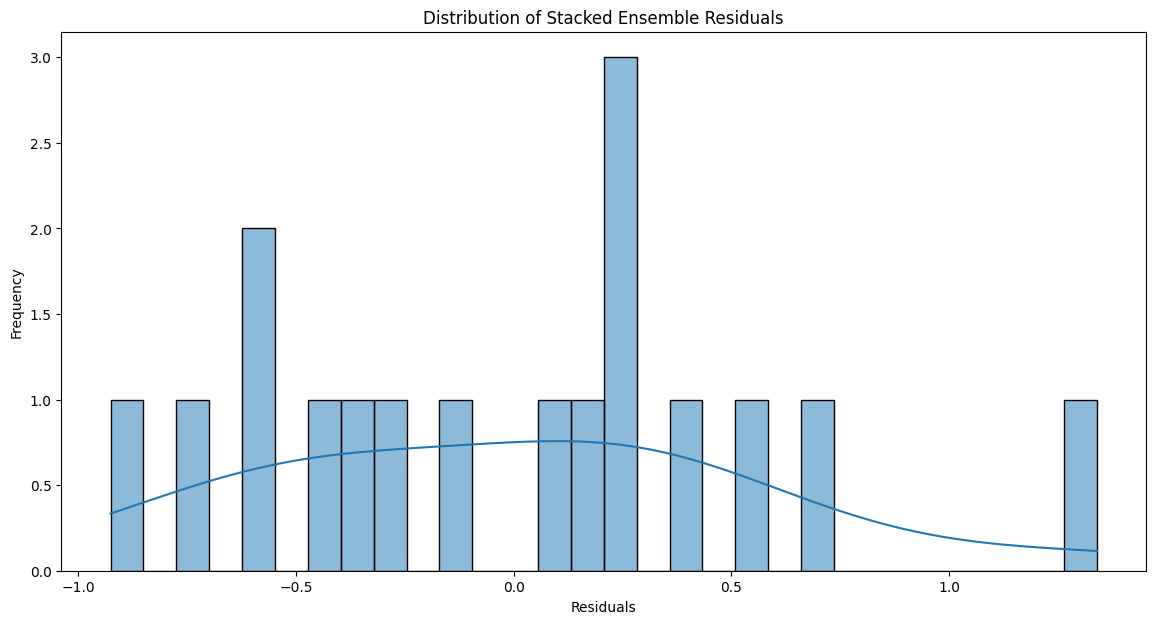

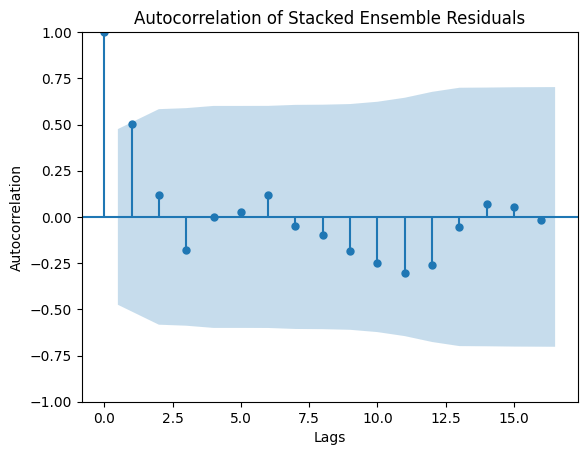

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


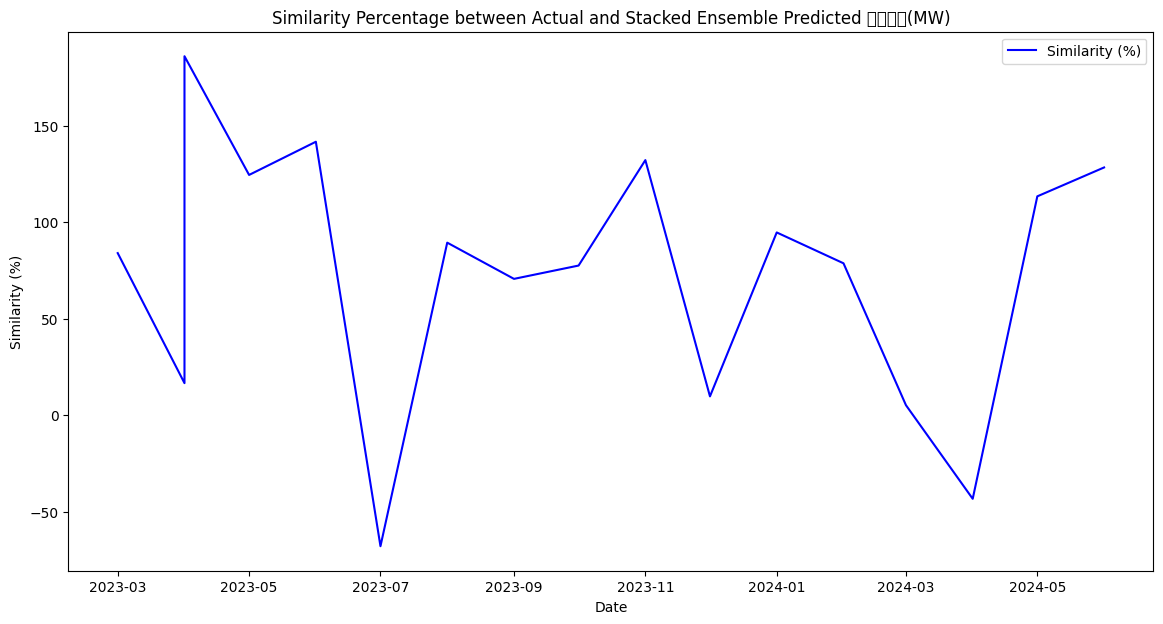

Stacked Ensemble Mean Squared Error: 0.3152623020644201
Stacked Ensemble Mean Absolute Error: 0.4659549918318675
Stacked Ensemble R2 Score: 0.7782121084759508
LSTM Performance:
Mean Squared Error: 1.2066092253827496
Mean Absolute Error: 0.8973732461596411
R2 Score: 0.1511471107115654

Random Forest Performance:
Mean Squared Error: 1.0197071337762882
Mean Absolute Error: 0.8755739131811691
R2 Score: 0.28263324320311023

XGBoost Performance:
Mean Squared Error: 1.1041585610152165
Mean Absolute Error: 0.8467088741452968
R2 Score: 0.2232214332249819

AdaBoost Performance:
Mean Squared Error: 1.2178680655537877
Mean Absolute Error: 0.9138247045201432
R2 Score: 0.1432264858661928

GBM Performance:
Mean Squared Error: 1.277623522662655
Mean Absolute Error: 0.8517195597522309
R2 Score: 0.10118835840075491

Voting Performance:
Mean Squared Error: 1.0474248548435237
Mean Absolute Error: 0.8780762580963382
R2 Score: 0.2631337506437438

Bagging Performance:
Mean Squared Error: 1.1068347054781589
M

<Figure size 1400x700 with 0 Axes>

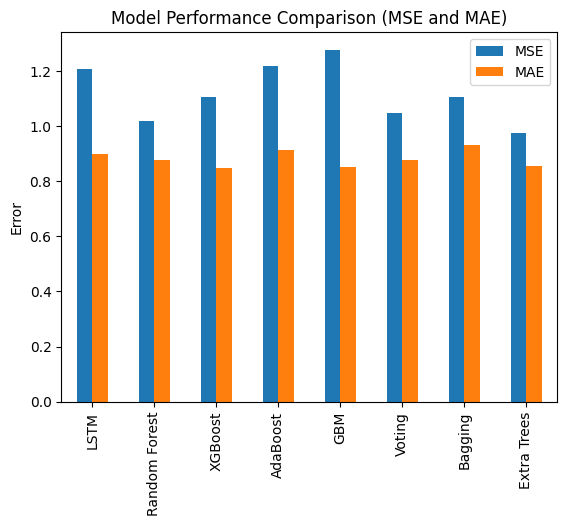

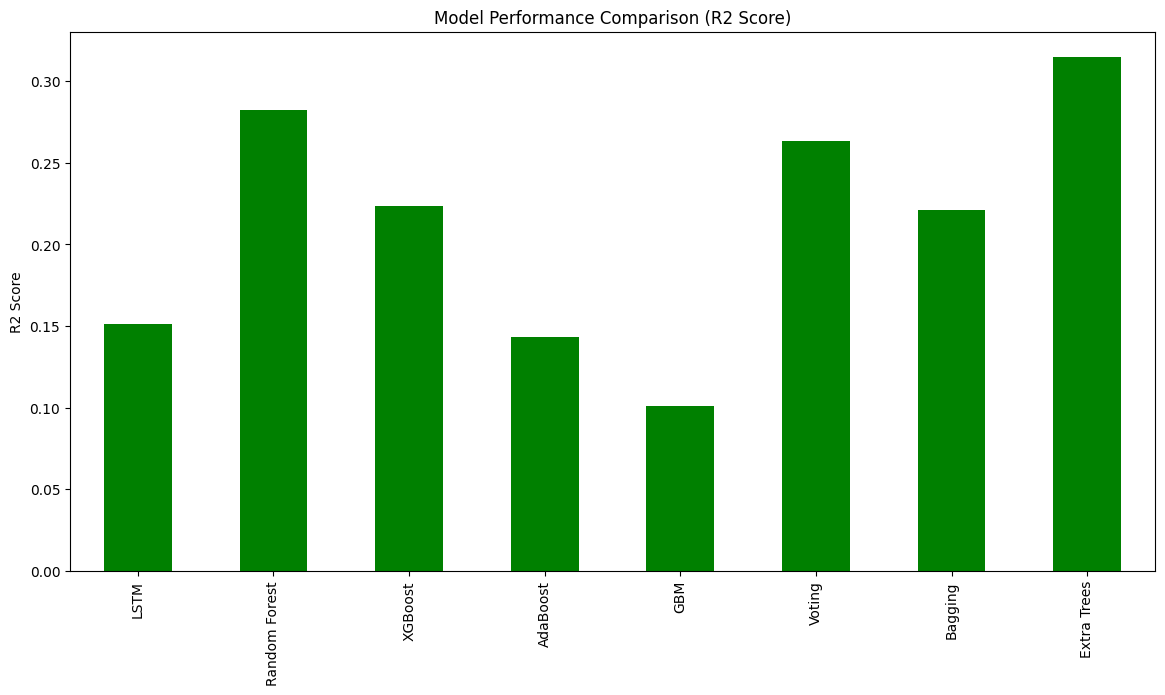

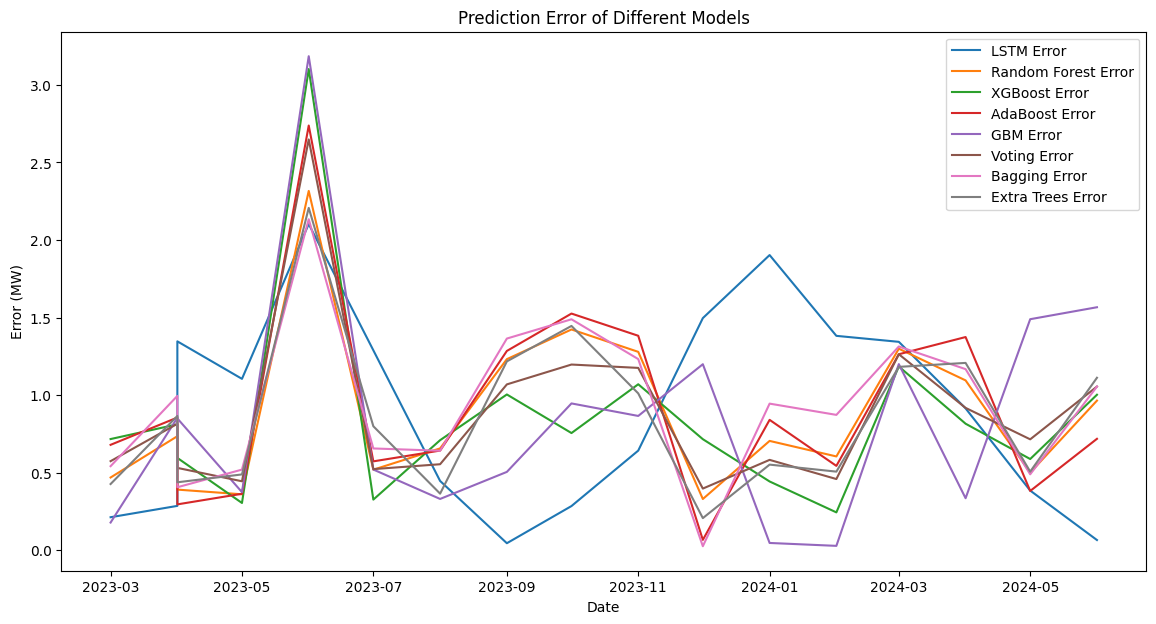

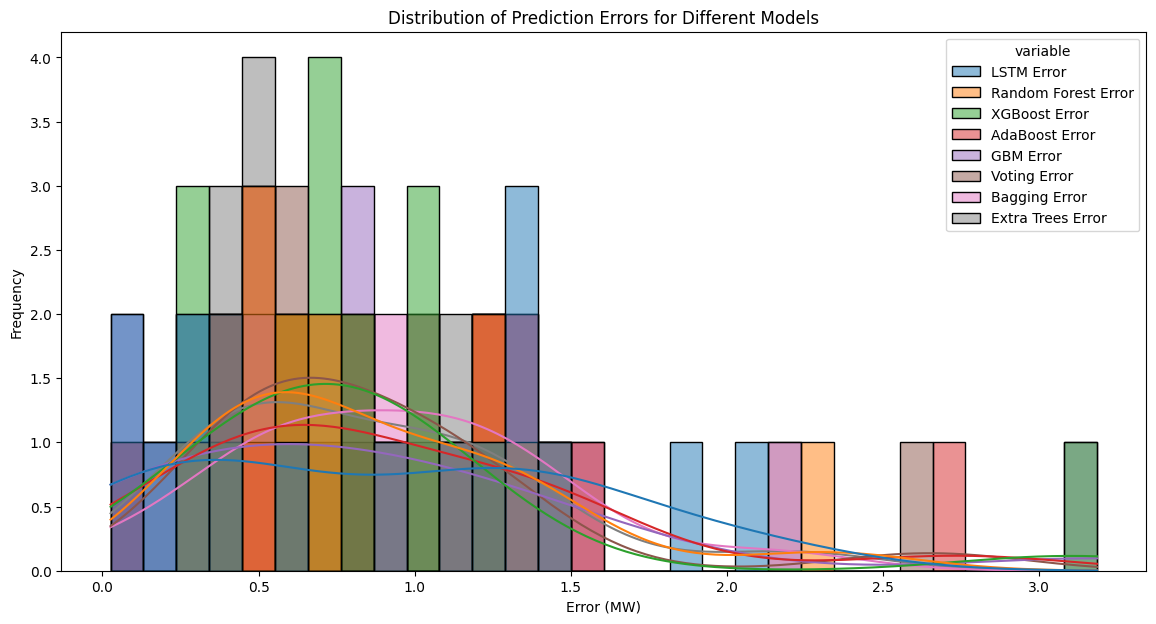

In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화 (표준정규화)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# y 값을 정규화하지 않음 (스케일링에서 제외)
y_test_actual = y_test  # y_test_actual을 스케일링에서 제외

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# 예측값은 정규화하지 않음 (원래 스케일로 유지)
lstm_predictions = lstm_predictions[:, target_index]

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions, rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_target)

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가한 후
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions,
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 실측값과의 차이를 백분율로 계산하여 데이터프레임에 추가
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    comparison_df[f'{model} Error (%)'] = 100 * np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)']

# 백분율 차이 시각화
plt.figure(figsize=(14, 7))
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error (%)'], label=f'{model} Error (%)')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.title('Prediction Error Percentage of Different Models')
plt.legend()
plt.show()

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()

# 예측값과 실제값의 차이 시각화
plt.figure(figsize=(14, 7))
for model in models.keys():
    comparison_df[f'{model} Error'] = np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)'])
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error'], label=f'{model} Error')
plt.xlabel('Date')
plt.ylabel('Error (MW)')
plt.title('Prediction Error of Different Models')
plt.legend()
plt.show()

# 예측값과 실제값의 차이 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df[[f'{model} Error' for model in models.keys()]].melt(), x='value', hue='variable', kde=True, bins=30)
plt.xlabel('Error (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors for Different Models')
plt.show()


Epoch 1/100
68/68 [==============================] - 3s 7ms/step - loss: 0.6837
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.5159
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4920
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4779
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4673
Epoch 6/100
68/68 [==============================] - 0s 7ms/step - loss: 0.4478
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4292
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3990
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3714
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3701
Epoch 11/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3432
Epoch 12/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3127
Epoch 13/100
68/68 [=================

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


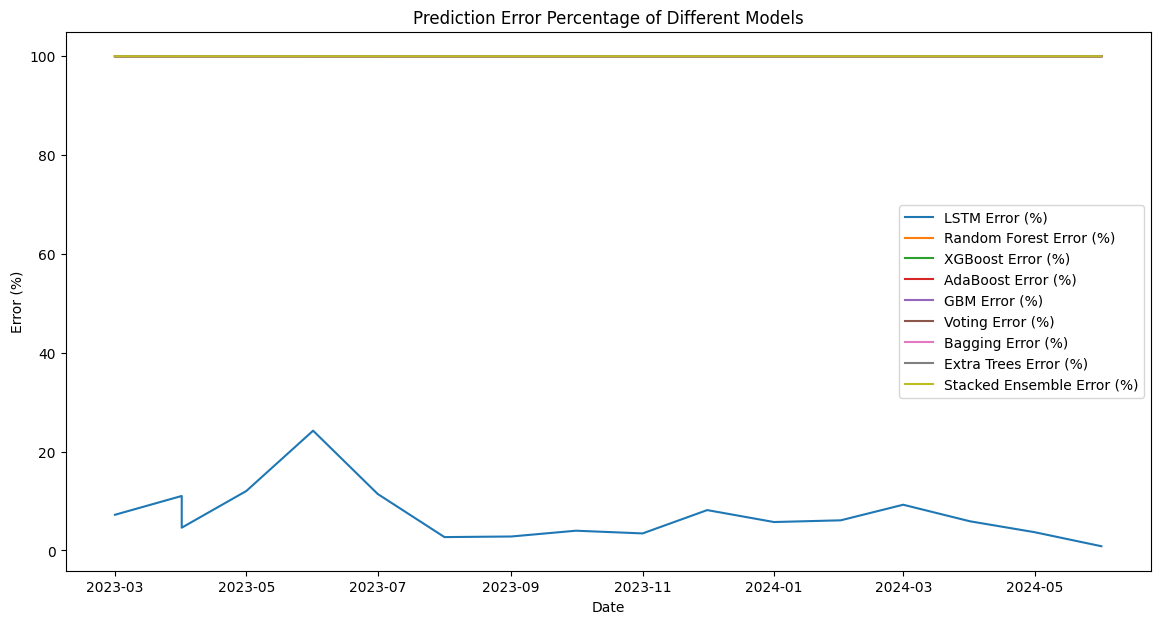

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


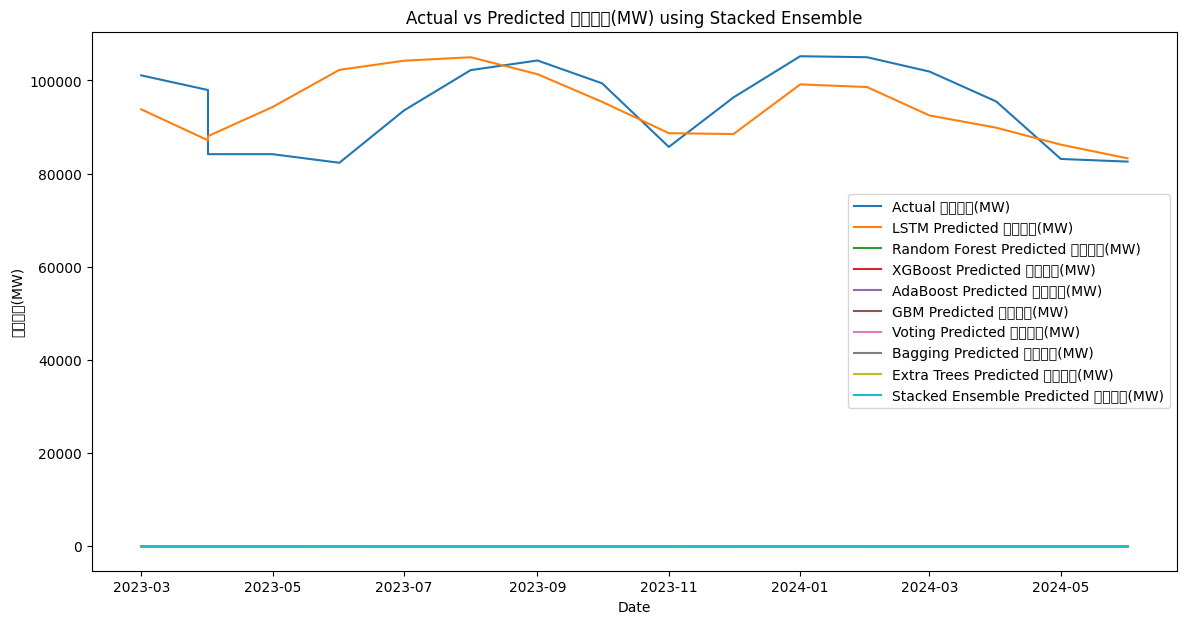

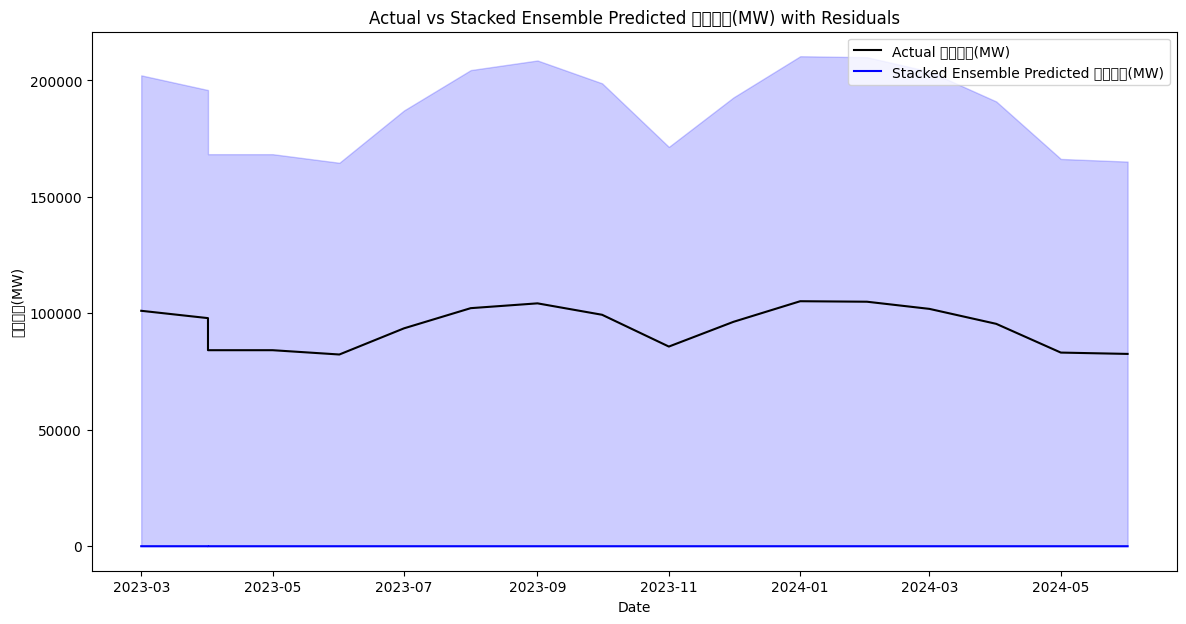

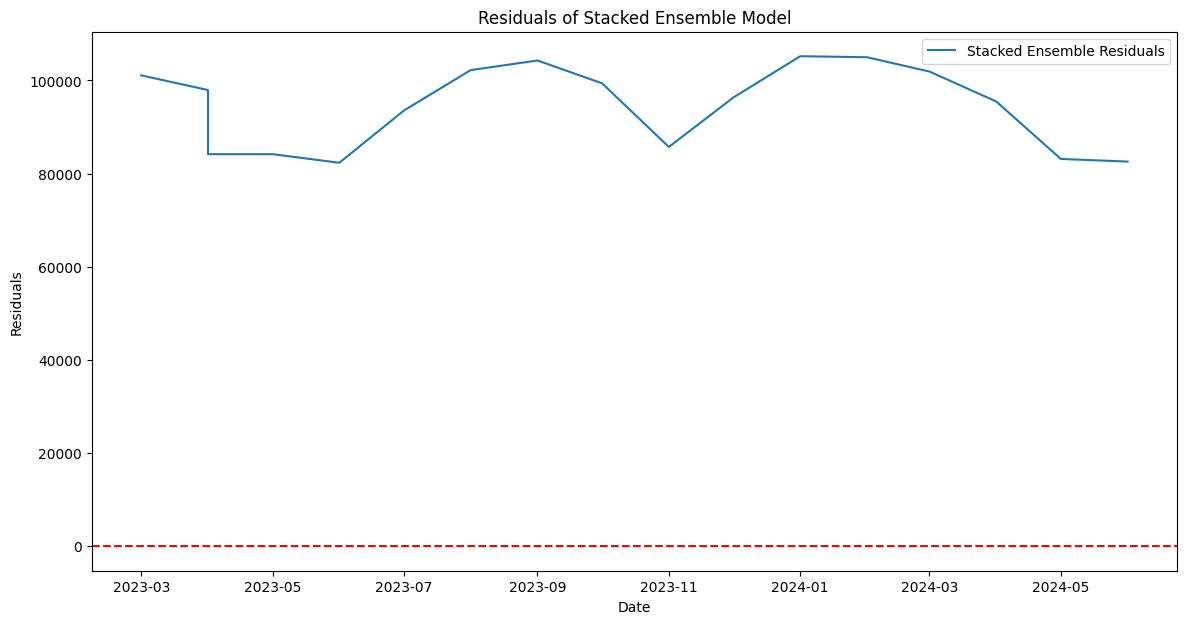

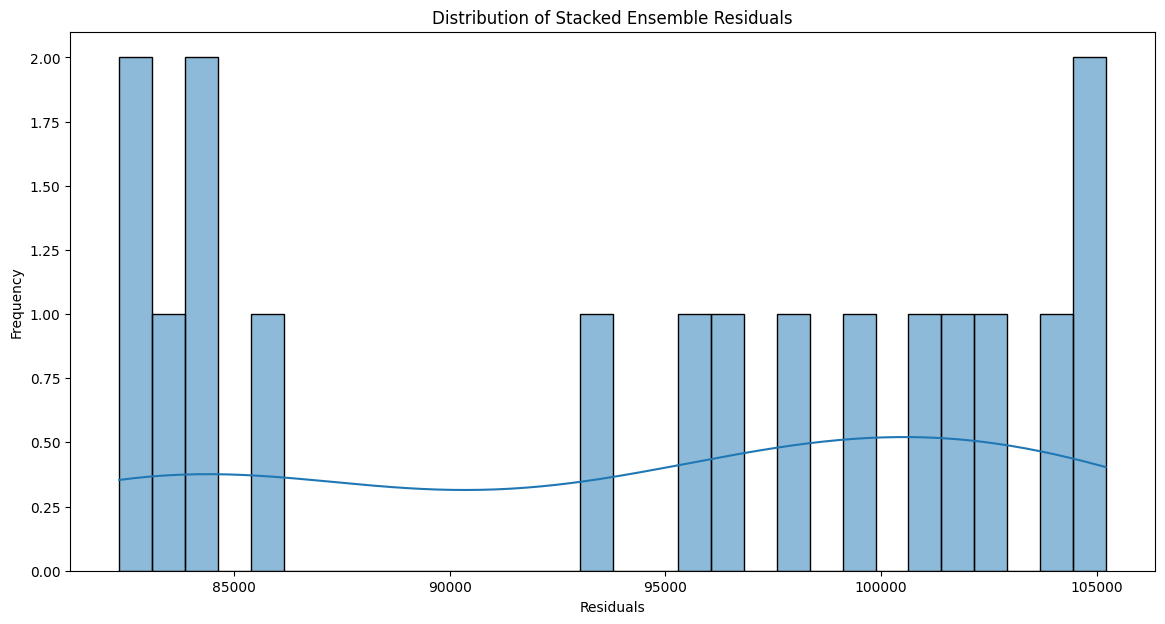

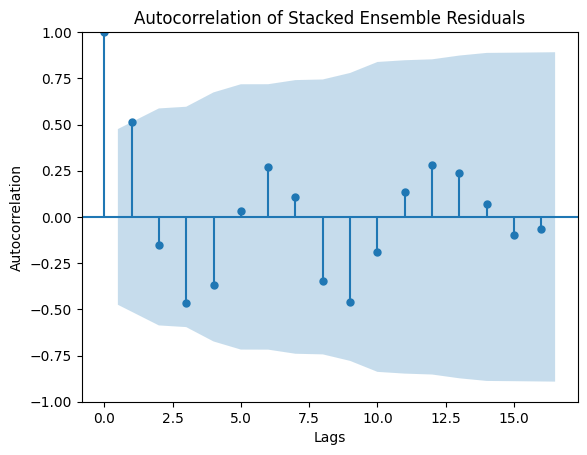

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44553 (\N{HANGUL SYLLABLE GEUB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


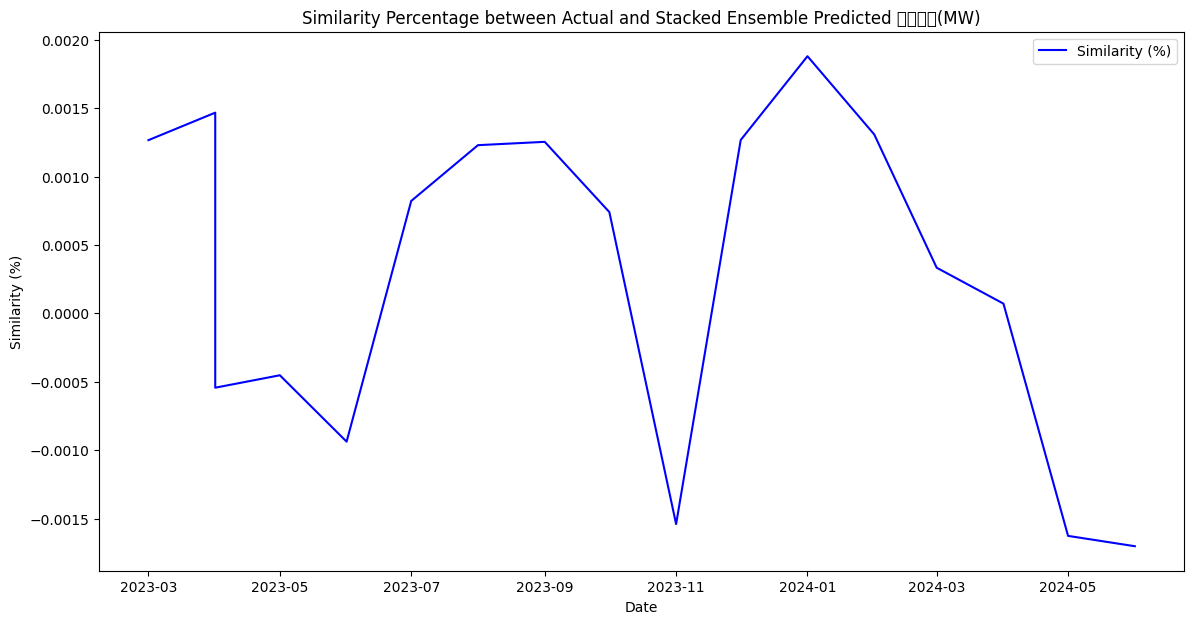

Stacked Ensemble Mean Squared Error: 8982503097.185337
Stacked Ensemble Mean Absolute Error: 94393.99541488735
Stacked Ensemble R2 Score: -123.25068258926608
LSTM Performance:
Mean Squared Error: 65312042.673440374
Mean Absolute Error: 6735.397977941177
R2 Score: 0.09656965372858128

Random Forest Performance:
Mean Squared Error: 8982530763.13577
Mean Absolute Error: 94394.08707637776
R2 Score: -123.25106527916762

XGBoost Performance:
Mean Squared Error: 8982501981.141624
Mean Absolute Error: 94393.9354733645
R2 Score: -123.25066715156552

AdaBoost Performance:
Mean Squared Error: 8982543222.540138
Mean Absolute Error: 94394.14979013504
R2 Score: -123.25123762416773

GBM Performance:
Mean Squared Error: 8982450259.755955
Mean Absolute Error: 94393.66117617836
R2 Score: -123.24995171429771

Voting Performance:
Mean Squared Error: 8982513165.312939
Mean Absolute Error: 94393.99207313787
R2 Score: -123.25082185687481

Bagging Performance:
Mean Squared Error: 8982545799.809725
Mean Absolu

<Figure size 1400x700 with 0 Axes>

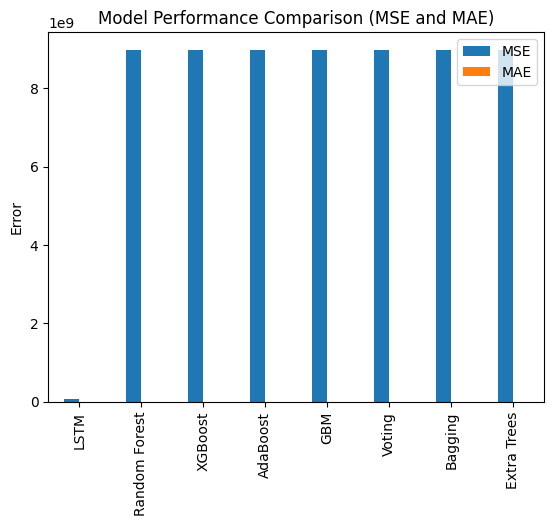

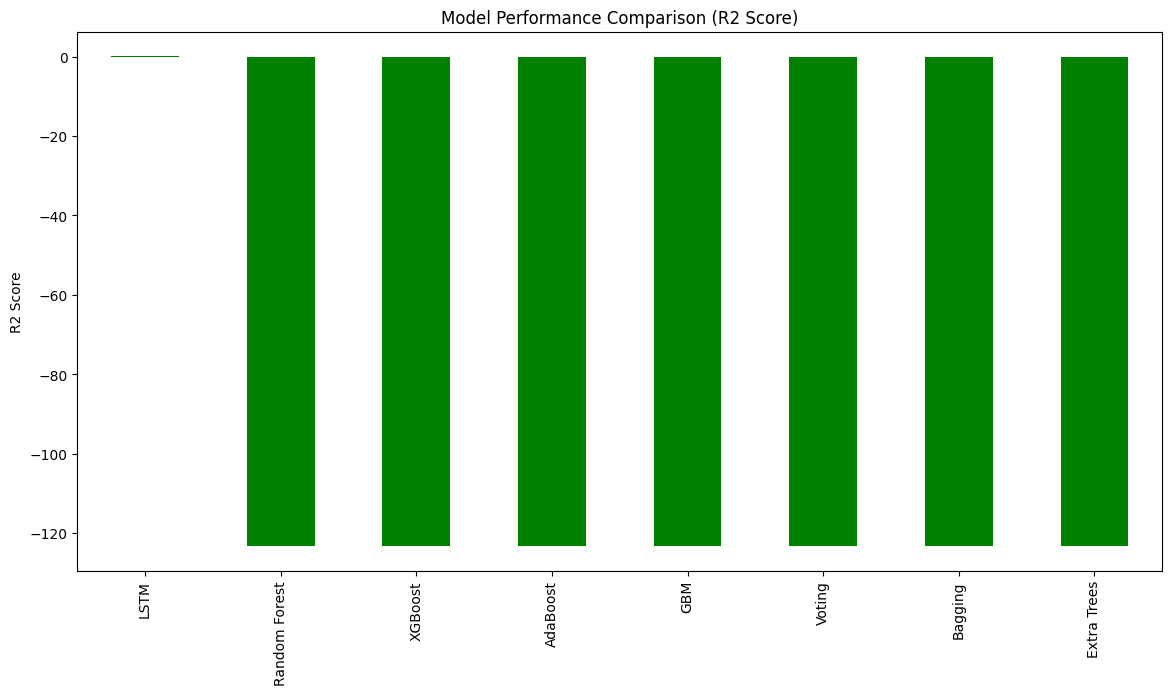

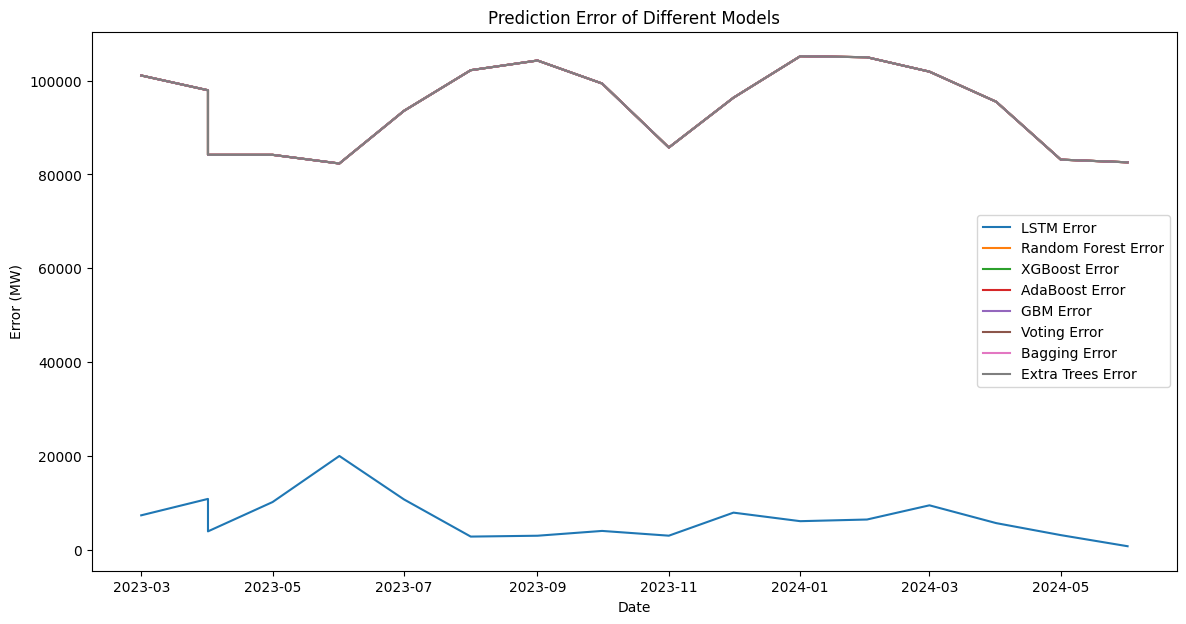

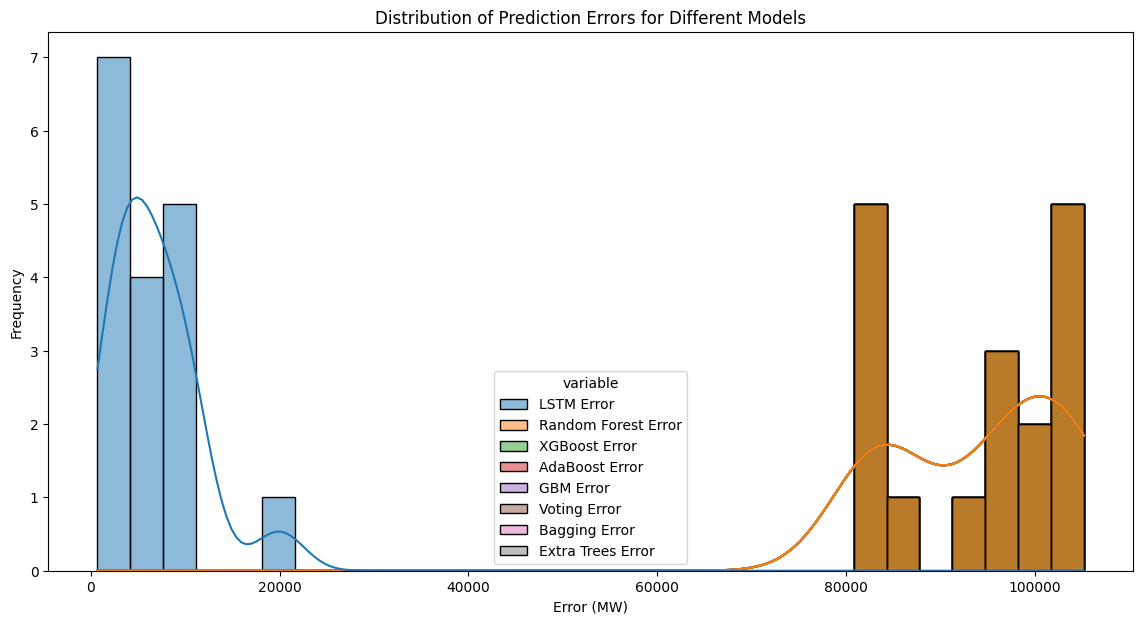

In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화 (표준정규화)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# 예측값은 역변환하여 원래 스케일로 복원
lstm_predictions = scaler.inverse_transform(lstm_predictions)[:, target_index]

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions, rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_target)

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)

# 메타 모델의 예측값을 데이터프레임에 추가한 후
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions,
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 실측값과의 차이를 백분율로 계산하여 데이터프레임에 추가
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    comparison_df[f'{model} Error (%)'] = 100 * np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)']

# 백분율 차이 시각화
plt.figure(figsize=(14, 7))
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error (%)'], label=f'{model} Error (%)')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.title('Prediction Error Percentage of Different Models')
plt.legend()
plt.show()

# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df[    'LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions,
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()

# 예측값과 실제값의 차이 시각화
plt.figure(figsize=(14, 7))
for model in models.keys():
    comparison_df[f'{model} Error'] = np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)'])
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error'], label=f'{model} Error')
plt.xlabel('Date')
plt.ylabel('Error (MW)')
plt.title('Prediction Error of Different Models')
plt.legend()
plt.show()

# 예측값과 실제값의 차이 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df[[f'{model} Error' for model in models.keys()]].melt(), x='value', hue='variable', kde=True, bins=30)
plt.xlabel('Error (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors for Different Models')
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor, ExtraTreesRegressor
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 데이터 로드 및 전처리는 생략 (이미 완료된 상태)
# market_capacity, fuel_cost, bid_volume, monthly_max_supply 데이터프레임 사용

# 데이터 병합
data = market_capacity.join(fuel_cost, how='inner')
data = data.join(bid_volume, how='inner', rsuffix='_입찰량')
data = data.join(monthly_max_supply, how='inner')

# 데이터 정규화 (표준정규화)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), :]
        X.append(a)
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

# Define the time step
time_step = 30

# Create the dataset
X, y = create_dataset(scaled_data, time_step)

# Split the dataset into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 타깃 변수 선택 ('공급능력(MW)')
target_index = data.columns.get_loc('공급능력(MW)')
y_train_target = y_train[:, target_index]
y_test_target = y_test[:, target_index]

# Inverse transform the actual test values for evaluation
y_test_actual = scaler.inverse_transform(y_test)

#### LSTM 모델

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(y_train.shape[1]))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=100)

# Make predictions
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform the predictions
lstm_predictions = scaler.inverse_transform(lstm_predictions)

#### 랜덤 포레스트 모델

# Random Forest 모델 정의 및 학습
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
rf_predictions = rf_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
rf_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], rf_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### XGBoost 모델

# XGBoost 모델 정의 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
xgb_predictions = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
xgb_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], xgb_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### AdaBoost 모델

# AdaBoost 모델 정의 및 학습
adaboost_model = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
adaboost_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
adaboost_predictions = adaboost_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
adaboost_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], adaboost_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### GBM 모델

# GBM 모델 정의 및 학습
gbm_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gbm_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
gbm_predictions = gbm_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
gbm_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], gbm_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Voting Regressor 모델

# Voting Regressor 정의 및 학습
voting_model = VotingRegressor(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgb', lgb.LGBMRegressor(objective='regression', n_estimators=100, max_depth=10, learning_rate=0.05, random_state=42)),
    ('adaboost', adaboost_model),
    ('gbm', gbm_model)
])
voting_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
voting_predictions = voting_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
voting_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], voting_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Bagging Regressor 모델

# Bagging Regressor 정의 및 학습
bagging_model = BaggingRegressor(base_estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=100, random_state=42)
bagging_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
bagging_predictions = bagging_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
bagging_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], bagging_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### Extra Trees Regressor 모델

# Extra Trees Regressor 정의 및 학습
et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
et_model.fit(X_train.reshape(X_train.shape[0], -1), y_train_target)

# 예측 수행
et_predictions = et_model.predict(X_test.reshape(X_test.shape[0], -1))

# 예측값 역변환
et_predictions = scaler.inverse_transform(np.concatenate([X_test[:, 0, :target_index], et_predictions.reshape(-1, 1), X_test[:, 0, target_index+1:]], axis=1))[:, target_index]

#### 메타 모델 학습 및 예측

# 개별 모델 예측을 결합한 데이터셋 생성
stacked_predictions = np.column_stack((lstm_predictions[:, target_index], rf_predictions, xgb_predictions, adaboost_predictions, gbm_predictions, voting_predictions, bagging_predictions, et_predictions))

# 메타 모델 정의 및 학습 (여기서는 간단하게 선형 회귀 사용)
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_test_actual[:, target_index])

# 메타 모델 예측 수행
meta_predictions = meta_model.predict(stacked_predictions)


# 메타 모델의 예측값을 데이터프레임에 추가한 후
comparison_df = pd.DataFrame({
    'Date': data.index[-len(meta_predictions):],
    'Actual 공급능력(MW)': y_test_actual[:, target_index],
    'LSTM Predicted 공급능력(MW)': lstm_predictions[:, target_index],
    'Random Forest Predicted 공급능력(MW)': rf_predictions,
    'XGBoost Predicted 공급능력(MW)': xgb_predictions,
    'AdaBoost Predicted 공급능력(MW)': adaboost_predictions,
    'GBM Predicted 공급능력(MW)': gbm_predictions,
    'Voting Predicted 공급능력(MW)': voting_predictions,
    'Bagging Predicted 공급능력(MW)': bagging_predictions,
    'Extra Trees Predicted 공급능력(MW)': et_predictions,
    'Stacked Ensemble Predicted 공급능력(MW)': meta_predictions
})

# 실측값과의 차이를 백분율로 계산하여 데이터프레임에 추가
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    comparison_df[f'{model} Error (%)'] = 100 * np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)']

# 백분율 차이 시각화
plt.figure(figsize=(14, 7))
for model in ['LSTM', 'Random Forest', 'XGBoost', 'AdaBoost', 'GBM', 'Voting', 'Bagging', 'Extra Trees', 'Stacked Ensemble']:
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error (%)'], label=f'{model} Error (%)')
plt.xlabel('Date')
plt.ylabel('Error (%)')
plt.title('Prediction Error Percentage of Different Models')
plt.legend()
plt.show()


# 잔차 계산
comparison_df['Stacked Ensemble Residuals'] = comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']

# 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['LSTM Predicted 공급능력(MW)'], label='LSTM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Random Forest Predicted 공급능력(MW)'], label='Random Forest Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['XGBoost Predicted 공급능력(MW)'], label='XGBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['AdaBoost Predicted 공급능력(MW)'], label='AdaBoost Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['GBM Predicted 공급능력(MW)'], label='GBM Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Voting Predicted 공급능력(MW)'], label='Voting Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Bagging Predicted 공급능력(MW)'], label='Bagging Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Extra Trees Predicted 공급능력(MW)'], label='Extra Trees Predicted 공급능력(MW)')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)')
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Predicted 공급능력(MW) using Stacked Ensemble')
plt.legend()
plt.show()

# 오차 시각화 (잔차 포함)
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Actual 공급능력(MW)'], label='Actual 공급능력(MW)', color='black')
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'], label='Stacked Ensemble Predicted 공급능력(MW)', color='blue')
plt.fill_between(comparison_df['Date'],
                 comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Residuals'],
                 comparison_df['Actual 공급능력(MW)'] + comparison_df['Stacked Ensemble Residuals'],
                 color='blue', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('공급능력(MW)')
plt.title('Actual vs Stacked Ensemble Predicted 공급능력(MW) with Residuals')
plt.legend()
plt.show()

# 잔차 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Stacked Ensemble Residuals'], label='Stacked Ensemble Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of Stacked Ensemble Model')
plt.legend()
plt.show()

# 잔차의 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df['Stacked Ensemble Residuals'], kde=True, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Stacked Ensemble Residuals')
plt.show()

# 잔차의 자기상관 확인
lags = min(30, len(comparison_df['Stacked Ensemble Residuals']) - 1)
sm.graphics.tsa.plot_acf(comparison_df['Stacked Ensemble Residuals'], lags=lags)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Stacked Ensemble Residuals')
plt.show()

# 예측 정확도 계산 (유사도 퍼센트)
comparison_df['Similarity (%)'] = 100 * (1 - np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df['Stacked Ensemble Predicted 공급능력(MW)']) / comparison_df['Actual 공급능력(MW)'])

# 유사도 퍼센트 시각화
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Similarity (%)'], label='Similarity (%)', color='blue')
plt.xlabel('Date')
plt.ylabel('Similarity (%)')
plt.title('Similarity Percentage between Actual and Stacked Ensemble Predicted 공급능력(MW)')
plt.legend()
plt.show()

# 정확도 메트릭스 계산
mse_ensemble = mean_squared_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
mae_ensemble = mean_absolute_error(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])
r2_ensemble = r2_score(comparison_df['Actual 공급능력(MW)'], comparison_df['Stacked Ensemble Predicted 공급능력(MW)'])

print("Stacked Ensemble Mean Squared Error:", mse_ensemble)
print("Stacked Ensemble Mean Absolute Error:", mae_ensemble)
print("Stacked Ensemble R2 Score:", r2_ensemble)

# 각 모델의 성능 평가
models = {
    'LSTM': lstm_predictions[:, target_index],
    'Random Forest': rf_predictions,
    'XGBoost': xgb_predictions,
    'AdaBoost': adaboost_predictions,
    'GBM': gbm_predictions,
    'Voting': voting_predictions,
    'Bagging': bagging_predictions,
    'Extra Trees': et_predictions
}

model_performance = {}

for name, predictions in models.items():
    mse = mean_squared_error(y_test_actual[:, target_index], predictions)
    mae = mean_absolute_error(y_test_actual[:, target_index], predictions)
    r2 = r2_score(y_test_actual[:, target_index], predictions)
    model_performance[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    print(f"{name} Performance:")
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"R2 Score: {r2}")
    print()

# 성능 결과를 DataFrame으로 변환
performance_df = pd.DataFrame(model_performance).T

# 모델 성능 비교 시각화
plt.figure(figsize=(14, 7))
performance_df[['MSE', 'MAE']].plot(kind='bar')
plt.title('Model Performance Comparison (MSE and MAE)')
plt.ylabel('Error')
plt.show()

plt.figure(figsize=(14, 7))
performance_df['R2'].plot(kind='bar', color='green')
plt.title('Model Performance Comparison (R2 Score)')
plt.ylabel('R2 Score')
plt.show()

# 예측값과 실제값의 차이 시각화
plt.figure(figsize=(14, 7))
for model in models.keys():
    comparison_df[f'{model} Error'] = np.abs(comparison_df['Actual 공급능력(MW)'] - comparison_df[f'{model} Predicted 공급능력(MW)'])
    plt.plot(comparison_df['Date'], comparison_df[f'{model} Error'], label=f'{model} Error')
plt.xlabel('Date')
plt.ylabel('Error (MW)')
plt.title('Prediction Error of Different Models')
plt.legend()
plt.show()

# 예측값과 실제값의 차이 분포 시각화
plt.figure(figsize=(14, 7))
sns.histplot(comparison_df[[f'{model} Error' for model in models.keys()]].melt(), x='value', hue='variable', kde=True, bins=30)
plt.xlabel('Error (MW)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors for Different Models')
plt.show()



Epoch 1/100
68/68 [==============================] - 3s 6ms/step - loss: 0.6764
Epoch 2/100
68/68 [==============================] - 0s 6ms/step - loss: 0.5177
Epoch 3/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4990
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4852
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4714
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4582
Epoch 7/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4585
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.4268
Epoch 9/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3942
Epoch 10/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3960
Epoch 11/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3616
Epoch 12/100
68/68 [==============================] - 0s 6ms/step - loss: 0.3533
Epoch 13/100
68/68 [=================